Fuente original: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page\
En Kaggle: https://www.kaggle.com/datasets/shuhengmo/uber-nyc-forhire-vehicles-trip-data-2021\
definición de datos: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_hvfhs.pdf

## Ejemplo prueba VTC NCY 2021

In [2]:
import pandas as pd

In [3]:
path = '../Data/uber-nyc-forhire-vehicles-trip-data-2021/versions/1/'
file = 'fhvhv_tripdata_2021-01.csv'

In [4]:
trips = pd.read_csv(path + file)

In [5]:
trips_na = trips.isna().sum()

/home/gonzalopc/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


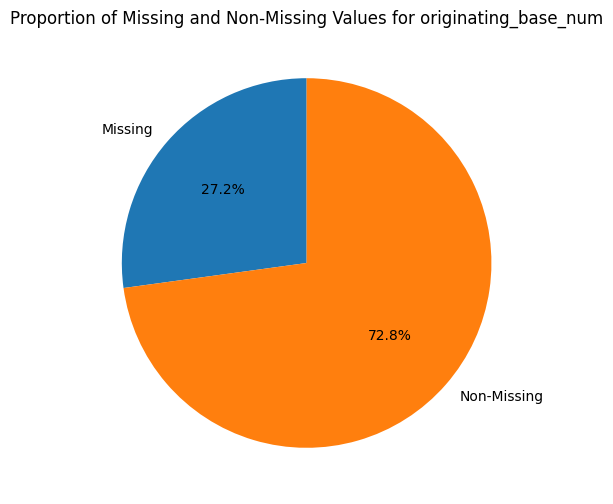

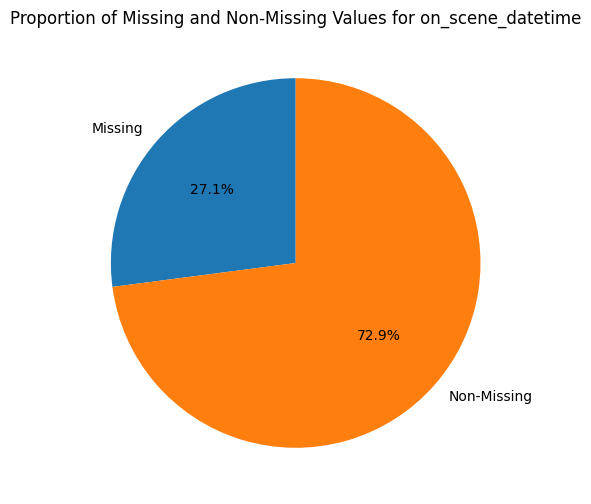

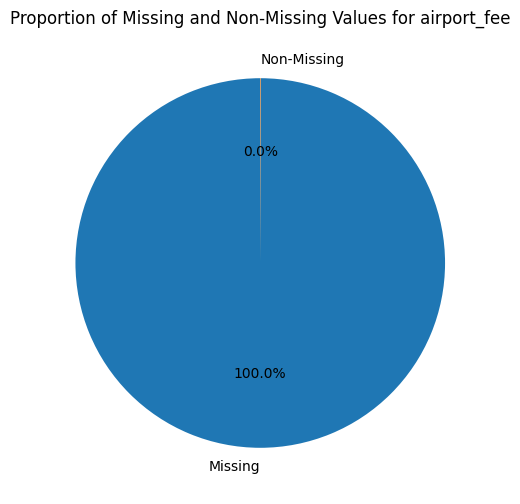

In [6]:
import matplotlib.pyplot as plt

# Variables to plot
variables = ['originating_base_num', 'on_scene_datetime', 'airport_fee']

# Create pie charts
for var in variables:
    proportions = [trips_na[var] / len(trips), (len(trips) - trips_na[var]) / len(trips)]
    labels = ['Missing', 'Non-Missing']
    
    plt.figure(figsize=(6, 6))
    plt.pie(proportions, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f'Proportion of Missing and Non-Missing Values for {var}')
    plt.show()

In [7]:
trips.drop(columns=['airport_fee'], inplace=True)

In [ ]:
datetime_columns = ['request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime']
new_trips.drop(columns=datetime_columns, inplace=True)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

# Define the columns
object_columns = new_trips.select_dtypes(include=['object']).columns.tolist()

object_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('object', object_transformer, object_columns)
    ],
    remainder='passthrough'
)


In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = new_trips.drop(columns=['driver_pay'])
y = new_trips['driver_pay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

### Regresor

In [ ]:

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=13431, n_estimators=10))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

# Predict on the training data
y_train_pred = pipeline.predict(X_train)

# Evaluate r2_score and mean_absolute_error
r2 = r2_score(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)

print(f'R2 Score on training data: {r2}')
print(f'Mean Absolute Error on training data: {mae}')

In [ ]:
# Predict on the test data
y_test_pred = pipeline.predict(X_test)

# Evaluate r2_score and mean_absolute_error
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f'R2 Score on test data: {r2_test}')
print(f'Mean Absolute Error on test data: {mae_test}')

### Clustering

In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 1: Create a copy of the trips dataframe
trips_copy = trips.copy()

# Step 2: Convert object type columns using OrdinalEncoder
object_columns = trips_copy.select_dtypes(include=['object']).columns.tolist()
encoder = OrdinalEncoder()
trips_copy[object_columns] = encoder.fit_transform(trips_copy[object_columns])

# Step 3: Drop the datetime variables
datetime_columns = ['request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime']
trips_copy.drop(columns=datetime_columns, inplace=True)

# Step 4: Apply StandardScaler
scaler = StandardScaler()
trips_scaled = scaler.fit_transform(trips_copy)

# Convert the scaled data back to a DataFrame
trips_scaled_df = pd.DataFrame(trips_scaled, columns=trips_copy.columns)

In [ ]:
from sklearn.impute import SimpleImputer

# Create an imputer object with mean strategy
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the dataframe
trips_scaled_df_imputed = pd.DataFrame(imputer.fit_transform(trips_scaled_df), columns=trips_scaled_df.columns)

# Display the first few rows of the imputed dataframe
print(trips_scaled_df_imputed.head())

In [ ]:
from sklearn.cluster import KMeans

# Apply KMeans
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(trips_scaled_df_imputed)

# Add the cluster labels to the dataframe
trips_scaled_df_imputed['cluster'] = kmeans.labels_

In [ ]:
trips_scaled_df_imputed['cluster'].value_counts()

## Visualizaciones

In [8]:
trips.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,bcf,sales_tax,congestion_surcharge,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02682,B02682,2021-01-01 00:28:09,2021-01-01 00:31:42,2021-01-01 00:33:44,2021-01-01 00:49:07,230,166,5.26,...,0.67,1.98,2.75,0.00,14.99,N,N,,N,N
1,HV0003,B02682,B02682,2021-01-01 00:45:56,2021-01-01 00:55:19,2021-01-01 00:55:19,2021-01-01 01:18:21,152,167,3.65,...,0.55,1.63,0.00,0.00,17.06,N,N,,N,N
2,HV0003,B02764,B02764,2021-01-01 00:21:15,2021-01-01 00:22:41,2021-01-01 00:23:56,2021-01-01 00:38:05,233,142,3.51,...,0.48,1.25,2.75,0.94,12.98,N,N,,N,N
3,HV0003,B02764,B02764,2021-01-01 00:39:12,2021-01-01 00:42:37,2021-01-01 00:42:51,2021-01-01 00:45:50,142,143,0.74,...,0.24,0.70,2.75,0.00,7.41,N,N,,N,N
4,HV0003,B02764,B02764,2021-01-01 00:46:11,2021-01-01 00:47:17,2021-01-01 00:48:14,2021-01-01 01:08:42,143,78,9.20,...,0.81,2.41,2.75,0.00,22.44,N,N,,N,N


In [9]:
trips.dtypes

hvfhs_license_num        object
dispatching_base_num     object
originating_base_num     object
request_datetime         object
on_scene_datetime        object
pickup_datetime          object
dropoff_datetime         object
PULocationID              int64
DOLocationID              int64
trip_miles              float64
trip_time                 int64
base_passenger_fare     float64
tolls                   float64
bcf                     float64
sales_tax               float64
congestion_surcharge    float64
tips                    float64
driver_pay              float64
shared_request_flag      object
shared_match_flag        object
access_a_ride_flag       object
wav_request_flag         object
wav_match_flag           object
dtype: object

### Visualización para cada variable

In [10]:
grouped_counts = trips.groupby('hvfhs_license_num')['hvfhs_license_num'].count()
print(grouped_counts)

hvfhs_license_num
HV0003    72925
HV0004      501
HV0005    26574
Name: hvfhs_license_num, dtype: int64


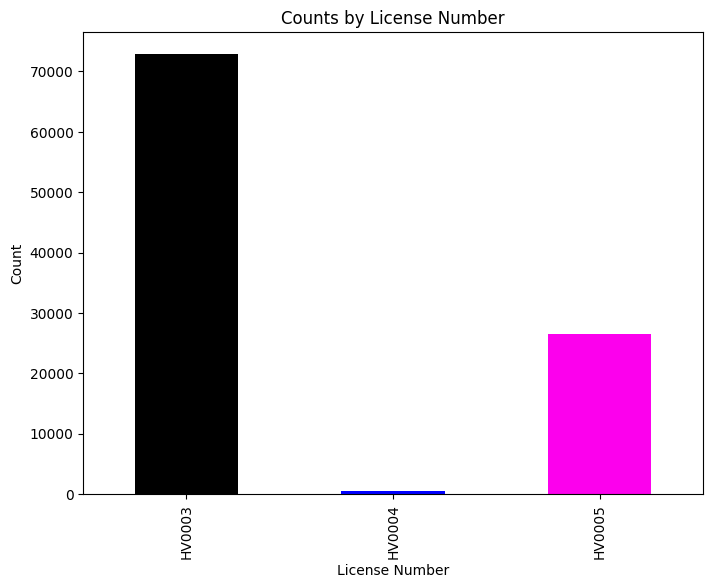

In [11]:
# Define colors for each category
colors = ['black' if index == 'HV0003' else '#fc00ed' if index == 'HV0005' else 'blue' for index in grouped_counts.index]

# Plot the bar chart
grouped_counts.plot(kind='bar', color=colors, figsize=(8, 6))

# Add labels and title
plt.xlabel('License Number')
plt.ylabel('Count')
plt.title('Counts by License Number')
plt.show()

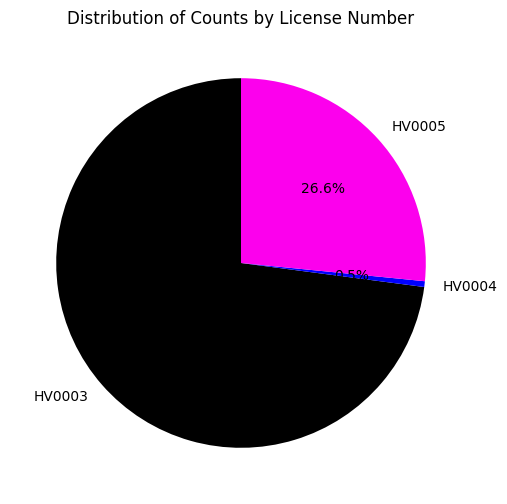

In [12]:
# Generate a pie chart for grouped_counts
plt.figure(figsize=(6, 6))
plt.pie(grouped_counts, labels=grouped_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Counts by License Number')
plt.show()

Incluir diferencia entre 'dispatching_base_num' y 'originating_base_num' desagregado por hvfhs_license_num

In [13]:
trips[['dispatching_base_num', 'originating_base_num']]

,dispatching_base_num,originating_base_num
0,B02682,B02682
1,B02682,B02682
2,B02764,B02764
3,B02764,B02764
4,B02764,B02764
...,...,...
99995,B02510,NaN
99996,B02510,NaN
99997,B02878,B02878
99998,B02510,NaN


In [14]:
len(trips[['dispatching_base_num', 'originating_base_num']].value_counts())

30

In [15]:
trips['dispatching_base_num'].value_counts()

dispatching_base_num
B02510    26566
B02872     7982
B02764     7930
B02765     5517
B02875     5408
B02869     4035
B02871     2781
B02887     2713
B02682     2659
B02878     2627
B02866     2575
B02864     2458
B02884     2405
B02883     2383
B02617     2302
B02876     2137
B02882     2089
B02835     1895
B02877     1836
B02867     1657
B02879     1652
B02888     1551
B02836     1509
B02889     1263
B02880     1045
B02395      842
B02870      832
B02865      512
B02800      501
B02512      330
B02844        8
Name: count, dtype: int64

In [16]:
trips[['dispatching_base_num', 'originating_base_num']].loc[trips['dispatching_base_num'] == 'B02510']

,dispatching_base_num,originating_base_num
5,B02510,NaN
6,B02510,NaN
18,B02510,NaN
20,B02510,NaN
21,B02510,NaN
...,...,...
99994,B02510,NaN
99995,B02510,NaN
99996,B02510,NaN
99998,B02510,NaN


In [17]:
trips[['dispatching_base_num', 'originating_base_num']].loc[trips['dispatching_base_num'] == 'B02800']

,dispatching_base_num,originating_base_num
13,B02800,NaN
14,B02800,NaN
60,B02800,NaN
61,B02800,NaN
62,B02800,NaN
...,...,...
99359,B02800,NaN
99380,B02800,NaN
99381,B02800,NaN
99489,B02800,NaN


In [18]:
trips[['dispatching_base_num', 'originating_base_num']].loc[trips['dispatching_base_num'] != trips['originating_base_num']]

,dispatching_base_num,originating_base_num
5,B02510,NaN
6,B02510,NaN
13,B02800,NaN
14,B02800,NaN
18,B02510,NaN
...,...,...
99994,B02510,NaN
99995,B02510,NaN
99996,B02510,NaN
99998,B02510,NaN


In [19]:
filtered_trips = trips[['dispatching_base_num', 'originating_base_num']].dropna().loc[
    trips['dispatching_base_num'] != trips['originating_base_num']
]
filtered_trips

,dispatching_base_num,originating_base_num
19283,B02844,B02510
25997,B02844,B02510
29910,B02844,B02510
65618,B02844,B02510
74167,B02844,B02510
97641,B02844,B02510
97671,B02844,B02510
98061,B02844,B02510


In [20]:
trips[['dispatching_base_num', 'originating_base_num']].loc[trips['dispatching_base_num'] == 'B02844']

,dispatching_base_num,originating_base_num
19283,B02844,B02510
25997,B02844,B02510
29910,B02844,B02510
65618,B02844,B02510
74167,B02844,B02510
97641,B02844,B02510
97671,B02844,B02510
98061,B02844,B02510


In [21]:
trips['originating_base_num'].fillna(trips['dispatching_base_num'], inplace=True)

/tmp/ipykernel_510929/3331019920.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trips['originating_base_num'].fillna(trips['dispatching_base_num'], inplace=True)


In [22]:
trips['request_datetime']

0        2021-01-01 00:28:09
1        2021-01-01 00:45:56
2        2021-01-01 00:21:15
3        2021-01-01 00:39:12
4        2021-01-01 00:46:11
                ...         
99995    2021-01-01 03:28:45
99996    2021-01-01 03:45:44
99997    2021-01-01 03:34:12
99998    2021-01-01 03:06:33
99999    2021-01-01 03:40:51
Name: request_datetime, Length: 100000, dtype: object

In [23]:
trips[['request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime']].sort_values(by='request_datetime')

,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime
25675,2020-12-31 23:35:24,2021-01-01 00:00:06,2021-01-01 00:02:06,2021-01-01 00:37:16
29813,2020-12-31 23:36:35,NaN,2021-01-01 00:05:53,2021-01-01 00:40:00
13821,2020-12-31 23:44:46,2021-01-01 00:16:39,2021-01-01 00:18:37,2021-01-01 00:36:49
7110,2020-12-31 23:46:27,2020-12-31 23:49:22,2021-01-01 00:02:46,2021-01-01 00:12:05
905,2020-12-31 23:46:29,NaN,2021-01-01 00:01:32,2021-01-01 00:17:37
...,...,...,...,...
99876,2021-01-01 03:55:20,2021-01-01 03:55:50,2021-01-01 03:57:25,2021-01-01 04:08:07
99797,2021-01-01 03:55:42,2021-01-01 03:57:47,2021-01-01 03:59:48,2021-01-01 04:35:09
99951,2021-01-01 03:56:24,2021-01-01 03:59:04,2021-01-01 03:59:17,2021-01-01 04:15:45
99510,2021-01-01 03:56:32,2021-01-01 03:58:50,2021-01-01 03:59:09,2021-01-01 04:04:56


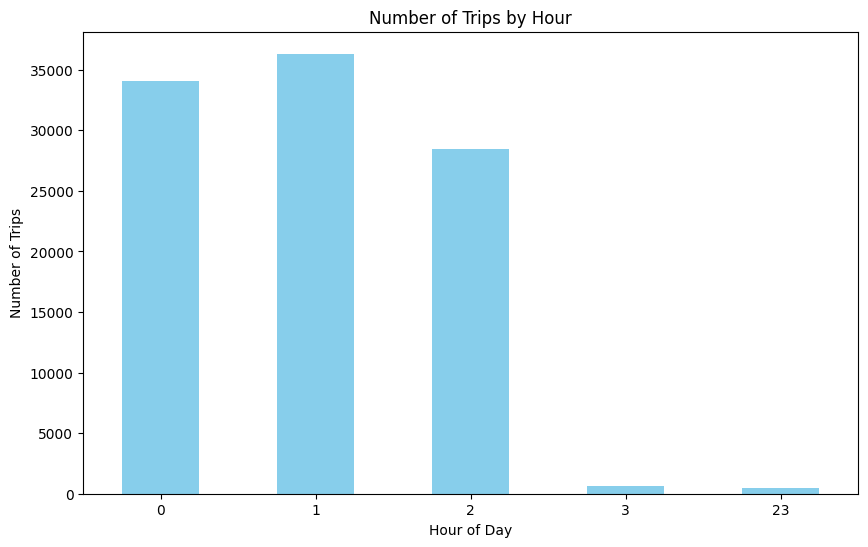

In [25]:
# Convert request_datetime to datetime format if not already
trips['request_datetime'] = pd.to_datetime(trips['request_datetime'])

# Extract the hour from request_datetime
trips['request_hour'] = trips['request_datetime'].dt.hour

# Group by hour and count the number of trips
trips_by_hour = trips.groupby('request_hour').size()

# Plot the histogram
plt.figure(figsize=(10, 6))
trips_by_hour.plot(kind='bar', color='skyblue')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Hour')
plt.xticks(rotation=0)
plt.show()


In [26]:
trips[['PULocationID', 'DOLocationID']]

,PULocationID,DOLocationID
0,230,166
1,152,167
2,233,142
3,142,143
4,143,78
...,...,...
99995,212,182
99996,78,47
99997,231,170
99998,170,7


In [27]:
trips[['PULocationID', 'DOLocationID']].value_counts()

PULocationID  DOLocationID
61            61              233
76            76              224
37            37              207
42            42              177
36            37              172
                             ... 
131           72                1
              75                1
              76                1
              80                1
265           265               1
Name: count, Length: 20005, dtype: int64

In [28]:
trips['same_location'] = trips['PULocationID'] == trips['DOLocationID']

In [29]:
trips['same_location'].value_counts()

same_location
False    93243
True      6757
Name: count, dtype: int64

In [30]:
same_location_trips = trips.loc[trips['PULocationID'] == trips['DOLocationID']]

In [31]:
same_location_trips['DOLocationID'].value_counts()

DOLocationID
61     233
76     224
37     207
42     177
216    160
      ... 
15       1
54       1
222      1
9        1
101      1
Name: count, Length: 232, dtype: int64

Representación en mapas

In [32]:
len(trips['DOLocationID'].unique())

256

In [33]:
import geopandas as gpd
gdf = gpd.read_file('../Data/taxi_zones/taxi_zone_NYC_id.geojson')
gdf.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,taxi_zone_lookup_LocationID,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,None,"MULTIPOLYGON (((933100.918 192536.086, 933091...."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,None,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,None,"MULTIPOLYGON (((1026308.77 256767.698, 1026495..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,None,"MULTIPOLYGON (((992073.467 203714.076, 992068...."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,None,"MULTIPOLYGON (((935843.31 144283.336, 936046.5..."


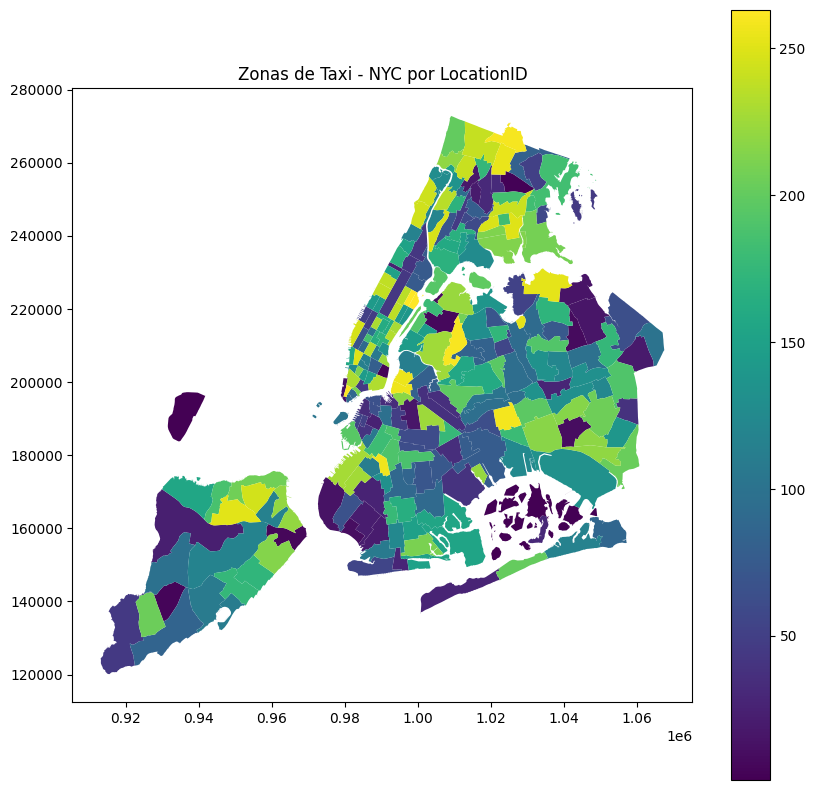

In [34]:
import matplotlib.pyplot as plt

gdf.plot(column="LocationID", legend=True, figsize=(10, 10))
plt.title("Zonas de Taxi - NYC por LocationID")
plt.show()

Análisis:
- SameLocation
- Origen: PULocationID
- Destion: DOLocationID

In [35]:
gdf.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,taxi_zone_lookup_LocationID,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,None,"MULTIPOLYGON (((933100.918 192536.086, 933091...."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,None,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,None,"MULTIPOLYGON (((1026308.77 256767.698, 1026495..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,None,"MULTIPOLYGON (((992073.467 203714.076, 992068...."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,None,"MULTIPOLYGON (((935843.31 144283.336, 936046.5..."


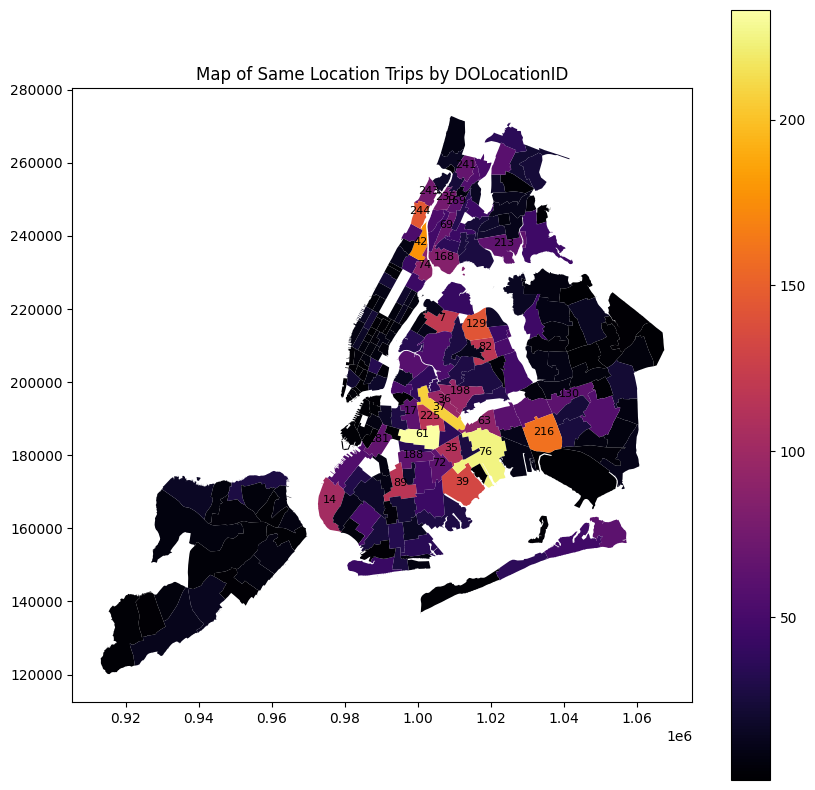

In [36]:
# Filter gdf to include only the DOLocationIDs present in same_location_trips
filtered_gdf = gdf[gdf['LocationID'].isin(same_location_trips['DOLocationID'].value_counts().index)]

# Merge the value counts with the filtered GeoDataFrame
value_counts = same_location_trips['DOLocationID'].value_counts()
filtered_gdf = filtered_gdf.merge(value_counts.rename('count'), left_on='LocationID', right_index=True)

# Plot the map
ax = filtered_gdf.plot(column='count', legend=True, cmap='inferno', figsize=(10, 10))
plt.title("Map of Same Location Trips by DOLocationID")

# Add labels for the top 10 LocationIDs
top_10 = value_counts.head(30)
for loc_id in top_10.index:
    row = filtered_gdf[filtered_gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

In [37]:
trips['PULocationID'].value_counts().head()

PULocationID
61     2057
37     2008
42     1596
244    1381
225    1356
Name: count, dtype: int64

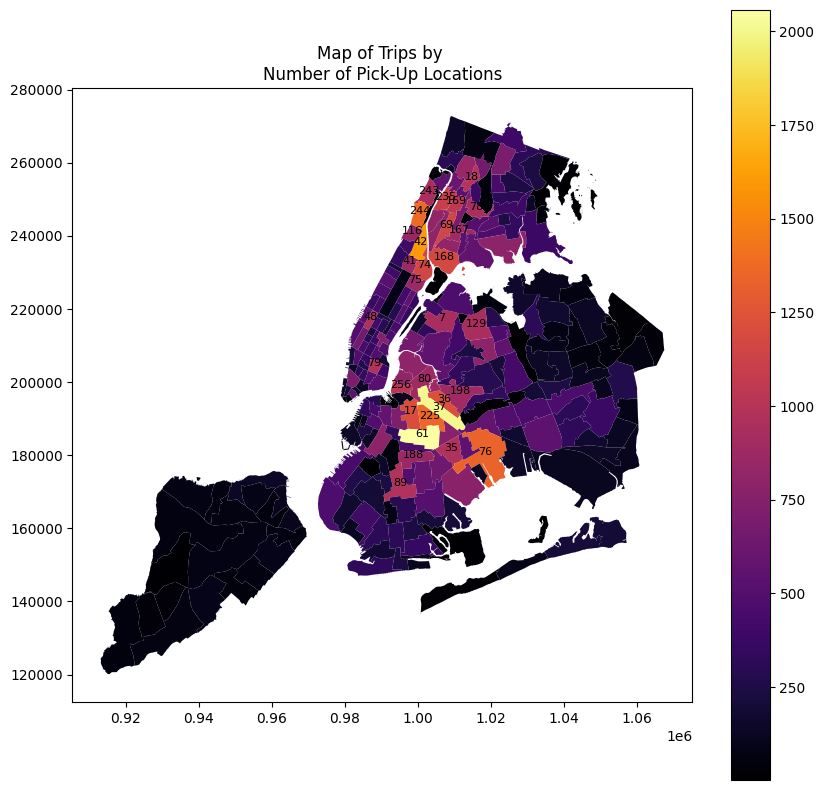

In [38]:
# Filter gdf to include only the DOLocationIDs present in same_location_trips
filtered_gdf = gdf[gdf['LocationID'].isin(trips['PULocationID'].value_counts().index)]

# Merge the value counts with the filtered GeoDataFrame
value_counts = trips['PULocationID'].value_counts()
filtered_gdf = filtered_gdf.merge(value_counts.rename('count'), left_on='LocationID', right_index=True)

# Plot the map
ax = filtered_gdf.plot(column='count', legend=True, cmap='inferno', figsize=(10, 10))
plt.title("Map of Trips by \nNumber of Pick-Up Locations")

# Add labels for the top 10 LocationIDs
top_10 = value_counts.head(30)
for loc_id in top_10.index:
    row = filtered_gdf[filtered_gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

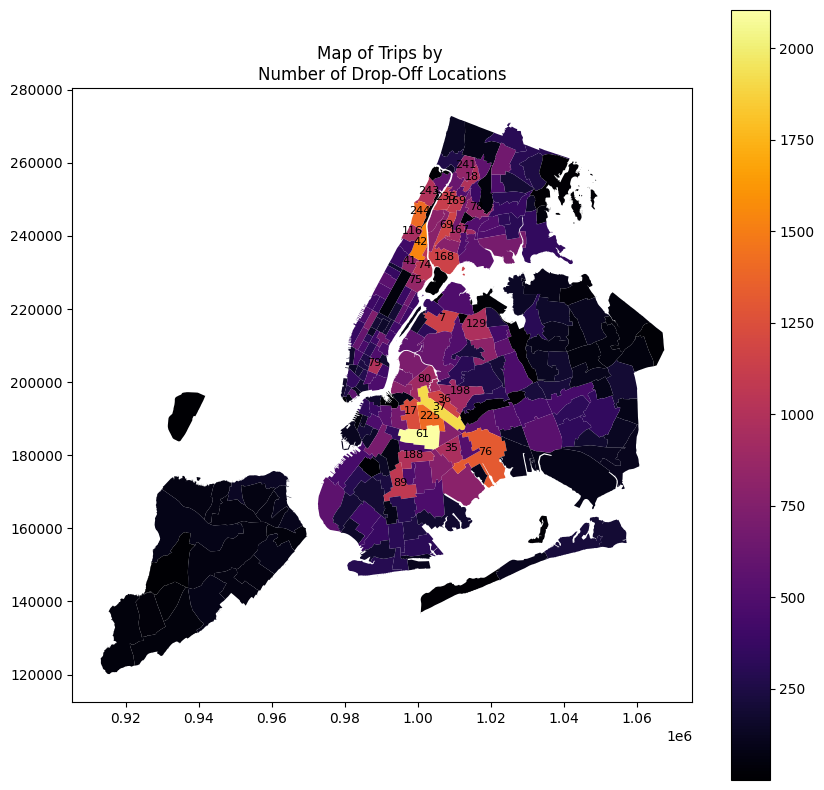

In [39]:
# Filter gdf to include only the DOLocationIDs present in same_location_trips
filtered_gdf = gdf[gdf['LocationID'].isin(trips['DOLocationID'].value_counts().index)]

# Merge the value counts with the filtered GeoDataFrame
value_counts = trips['DOLocationID'].value_counts()
filtered_gdf = filtered_gdf.merge(value_counts.rename('count'), left_on='LocationID', right_index=True)

# Plot the map
ax = filtered_gdf.plot(column='count', legend=True, cmap='inferno', figsize=(10, 10))
plt.title("Map of Trips by \nNumber of Drop-Off Locations")

# Add labels for the top 10 LocationIDs
top_10 = value_counts.head(30)
for loc_id in top_10.index:
    row = filtered_gdf[filtered_gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

Otros gráficos:
- Trayectos más frecuentes

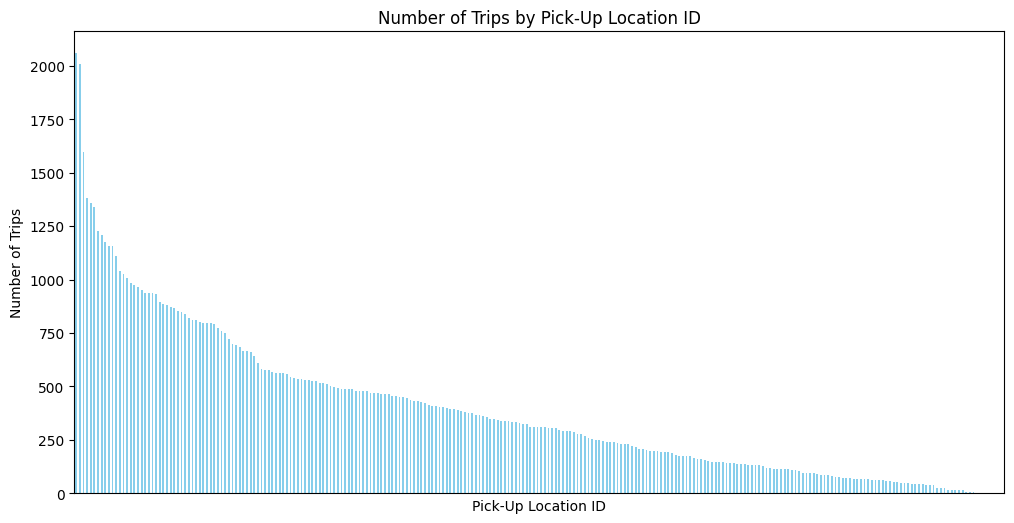

In [40]:
# Generate a bar plot for trips['PULocationID'] ordered by value_counts()
pulocation_counts = trips['PULocationID'].value_counts()

# Plot the bar chart
plt.figure(figsize=(12, 6))
pulocation_counts.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Pick-Up Location ID')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Pick-Up Location ID')

# Remove x-ticks
plt.xticks([])

plt.show()

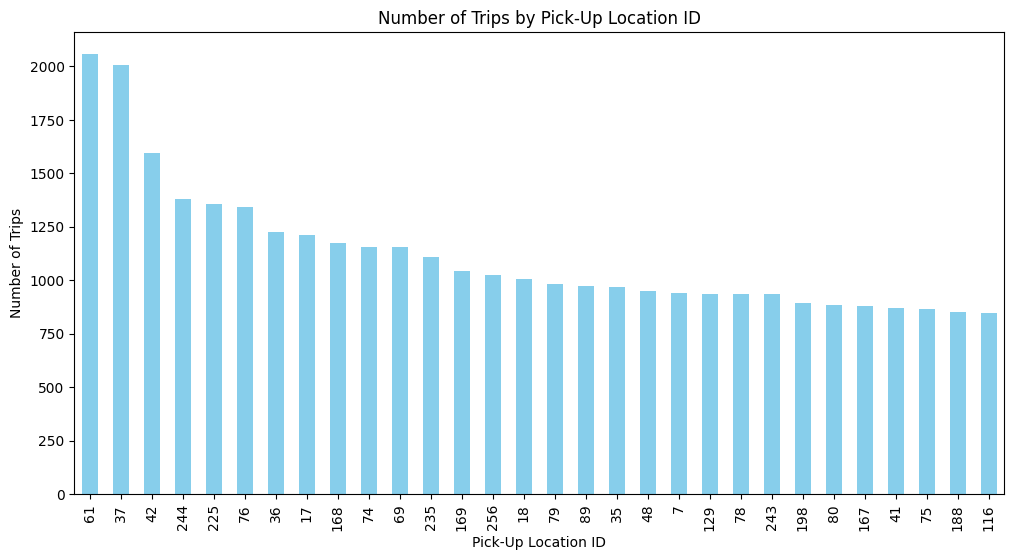

In [41]:
# Generate a bar plot for trips['PULocationID'] ordered by value_counts()
pulocation_counts = trips['PULocationID'].value_counts().head(30)

# Plot the bar chart
plt.figure(figsize=(12, 6))
pulocation_counts.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Pick-Up Location ID')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Pick-Up Location ID')

# Remove x-ticks
# plt.xticks([])

plt.show()

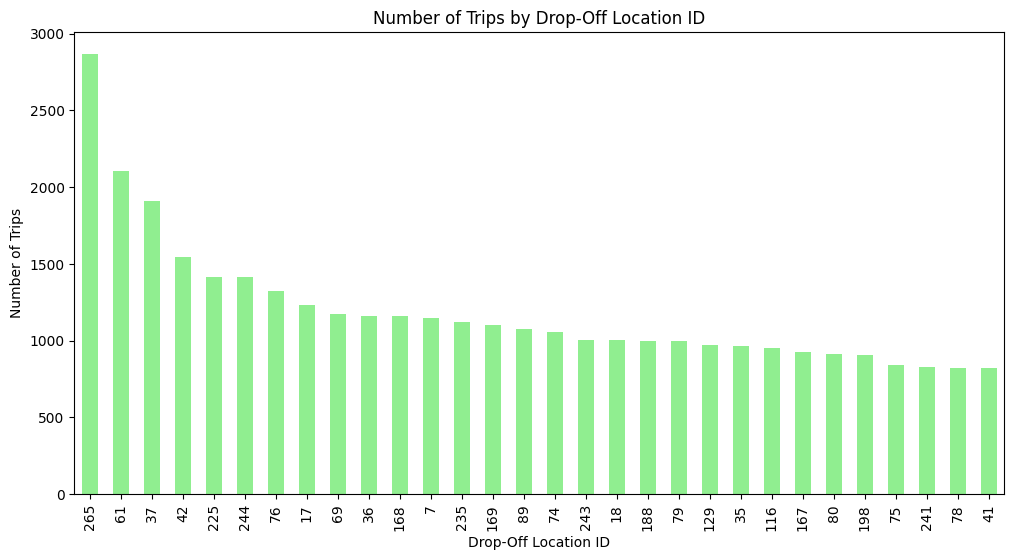

In [42]:
# Generate a bar plot for trips['PULocationID'] ordered by value_counts()
dolocation_counts = trips['DOLocationID'].value_counts().head(30)

# Plot the bar chart
plt.figure(figsize=(12, 6))
dolocation_counts.plot(kind='bar', color='lightgreen')

# Add labels and title
plt.xlabel('Drop-Off Location ID')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Drop-Off Location ID')

# Remove x-ticks
# plt.xticks([])

plt.show()

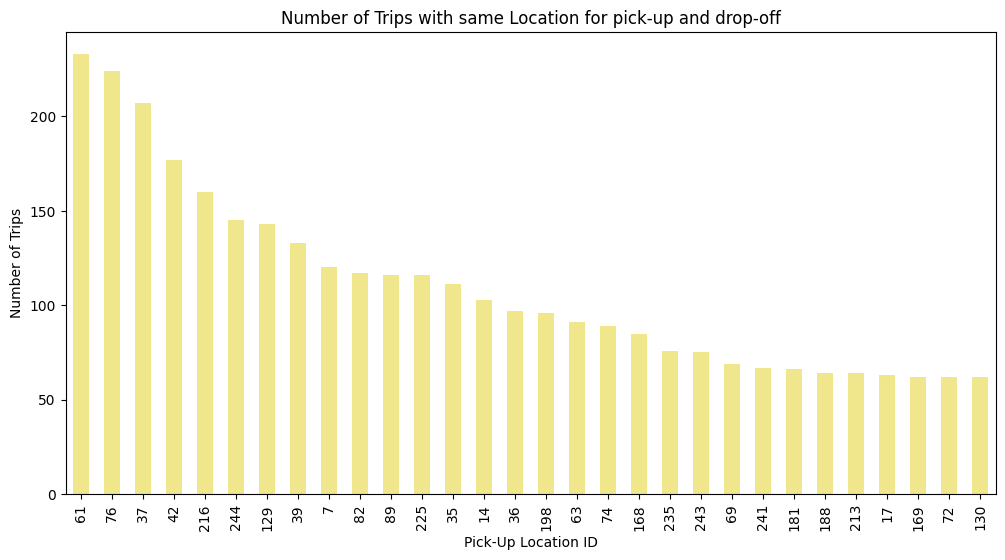

In [43]:
# Generate a bar plot for trips['PULocationID'] ordered by value_counts()
sametrip_counts = same_location_trips['DOLocationID'].value_counts().head(30)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sametrip_counts.plot(kind='bar', color='khaki')

# Add labels and title
plt.xlabel('Pick-Up Location ID')
plt.ylabel('Number of Trips')
plt.title('Number of Trips with same Location for pick-up and drop-off')

# Remove x-ticks
# plt.xticks([])

plt.show()

Agrupar barras por Boroughs
- ¿Cuanto representa trips with same origin/destination sobre el total de Drop-Offs o Pick-Ups?

In [44]:
gdf.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,taxi_zone_lookup_LocationID,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,None,"MULTIPOLYGON (((933100.918 192536.086, 933091...."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,None,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,None,"MULTIPOLYGON (((1026308.77 256767.698, 1026495..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,None,"MULTIPOLYGON (((992073.467 203714.076, 992068...."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,None,"MULTIPOLYGON (((935843.31 144283.336, 936046.5..."


In [45]:
# Map PULocationID to borough using gdf
# Ensure LocationID is unique in gdf
if not gdf['LocationID'].is_unique:
	gdf = gdf.drop_duplicates(subset='LocationID')

# Map PULocationID to borough using gdf
pulocation_to_borough = gdf.set_index('LocationID')['borough']


In [46]:
trips['PUborough'] = trips['PULocationID'].map(pulocation_to_borough)
trips['DOborough'] = trips['DOLocationID'].map(pulocation_to_borough)
same_location_trips['borough'] = same_location_trips['DOLocationID'].map(pulocation_to_borough)

/tmp/ipykernel_510929/3629663597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_location_trips['borough'] = same_location_trips['DOLocationID'].map(pulocation_to_borough)


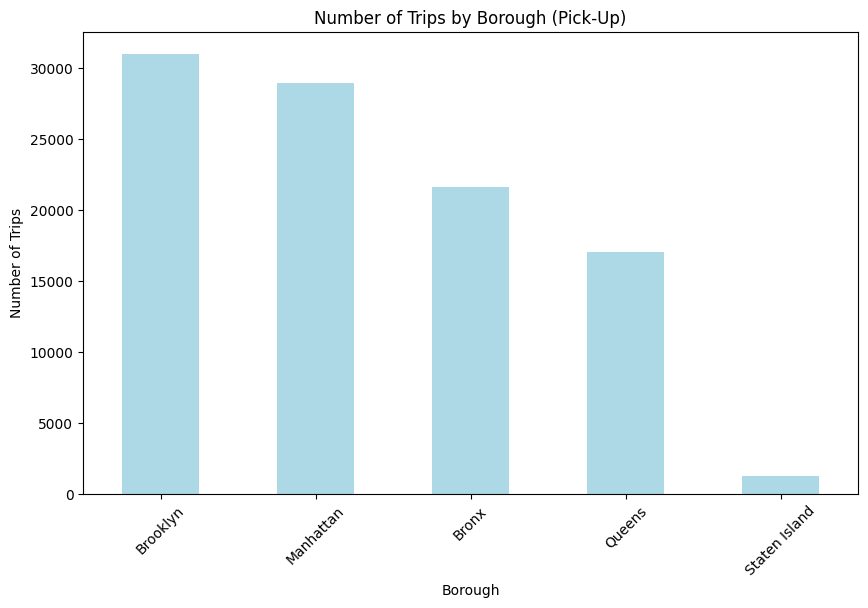

In [47]:
# Group by borough and count the number of trips
borough_counts = trips['PUborough'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
borough_counts.plot(kind='bar', color='lightblue')

# Add labels and title
plt.xlabel('Borough')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Borough (Pick-Up)')
plt.xticks(rotation=45)
plt.show()

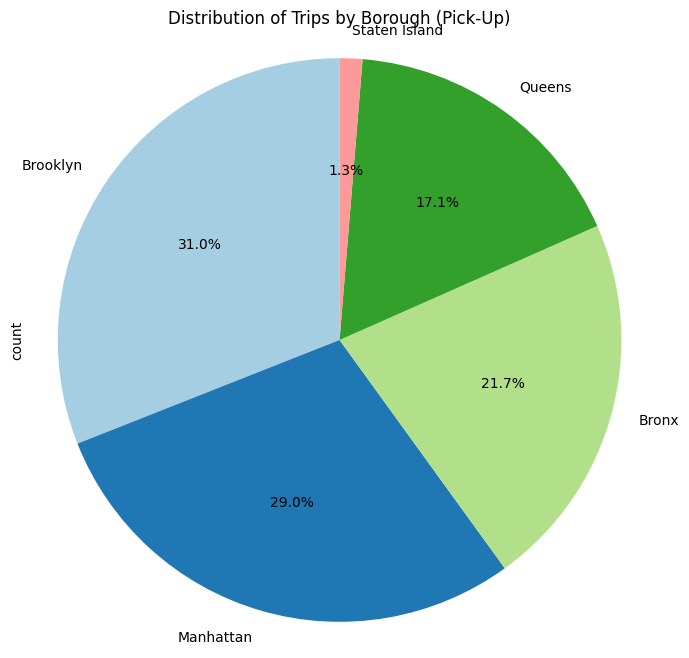

In [57]:
# Generate a pie chart for borough_counts
borough_counts = trips['PUborough'].value_counts()

plt.figure(figsize=(8, 8))
borough_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Add title
plt.title('Distribution of Trips by Borough (Pick-Up)')

# Ensure the pie chart is a circle
plt.axis('equal')

plt.show()

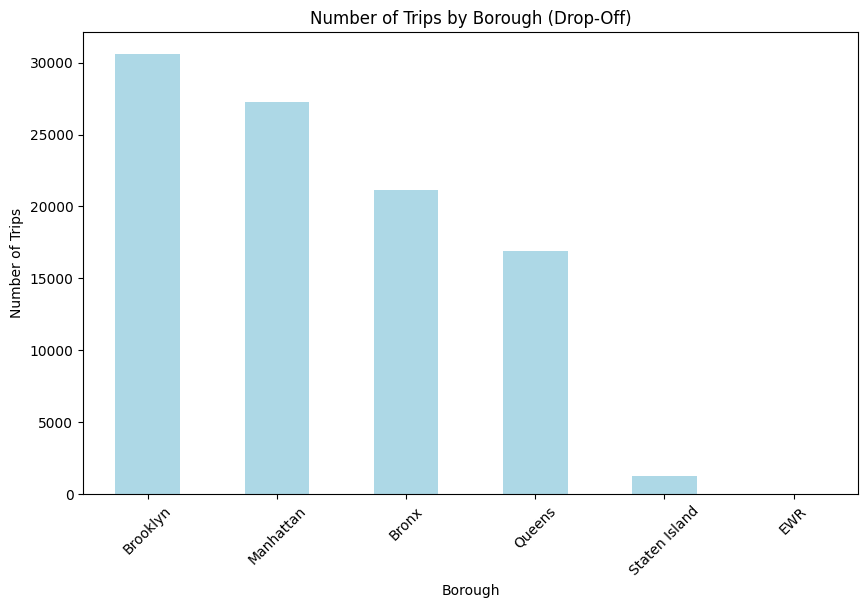

In [48]:
# Group by borough and count the number of trips
borough_counts = trips['DOborough'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
borough_counts.plot(kind='bar', color='lightblue')

# Add labels and title
plt.xlabel('Borough')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Borough (Drop-Off)')
plt.xticks(rotation=45)
plt.show()

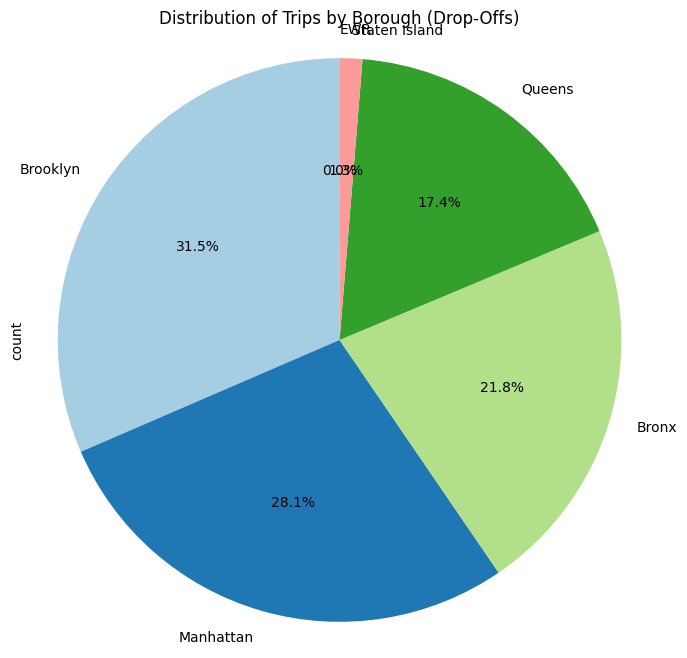

In [58]:
# Generate a pie chart for borough_counts
borough_counts = trips['DOborough'].value_counts()

plt.figure(figsize=(8, 8))
borough_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Add title
plt.title('Distribution of Trips by Borough (Drop-Offs)')

# Ensure the pie chart is a circle
plt.axis('equal')

plt.show()

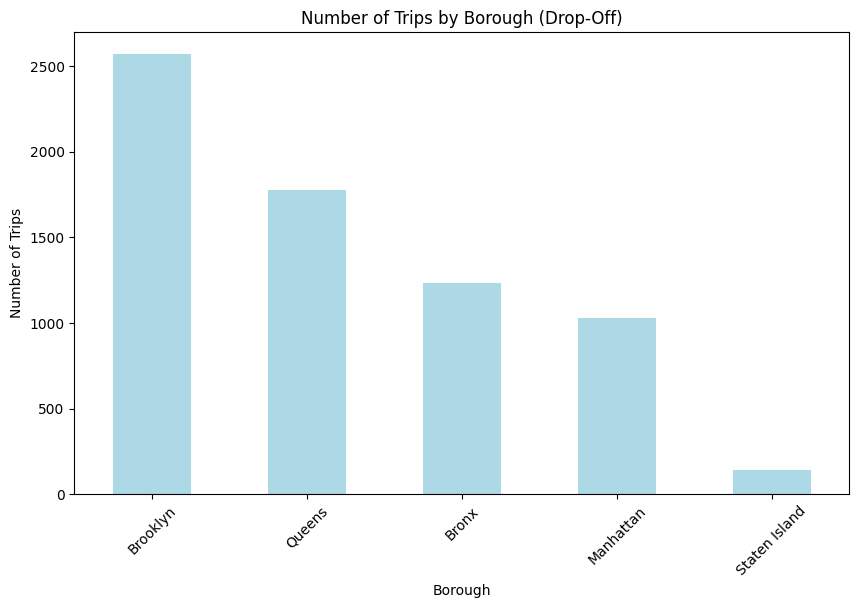

In [ ]:
# Group by borough and count the number of trips
borough_counts = same_location_trips['borough'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
borough_counts.plot(kind='bar', color='lightblue')

# Add labels and title
plt.xlabel('Borough')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Borough (Same Location)')
plt.xticks(rotation=45)
plt.show()

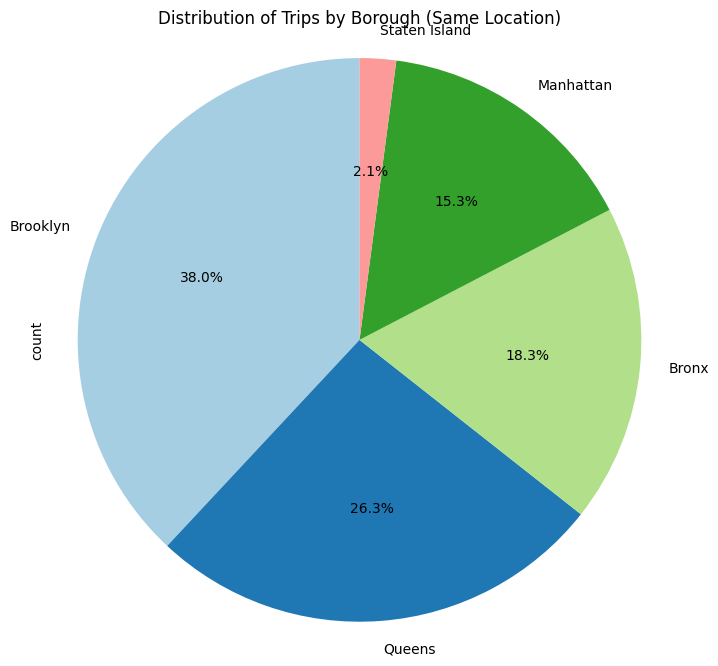

In [59]:
# Generate a pie chart for borough_counts
borough_counts = same_location_trips['borough'].value_counts()

plt.figure(figsize=(8, 8))
borough_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Add title
plt.title('Distribution of Trips by Borough (Same Location)')

# Ensure the pie chart is a circle
plt.axis('equal')

plt.show()

In [50]:
trips[['trip_miles','trip_time']]

,trip_miles,trip_time
0,5.260,923
1,3.650,1382
2,3.510,849
3,0.740,179
4,9.200,1228
...,...,...
99995,2.020,549
99996,2.701,1223
99997,3.690,1296
99998,5.349,1199


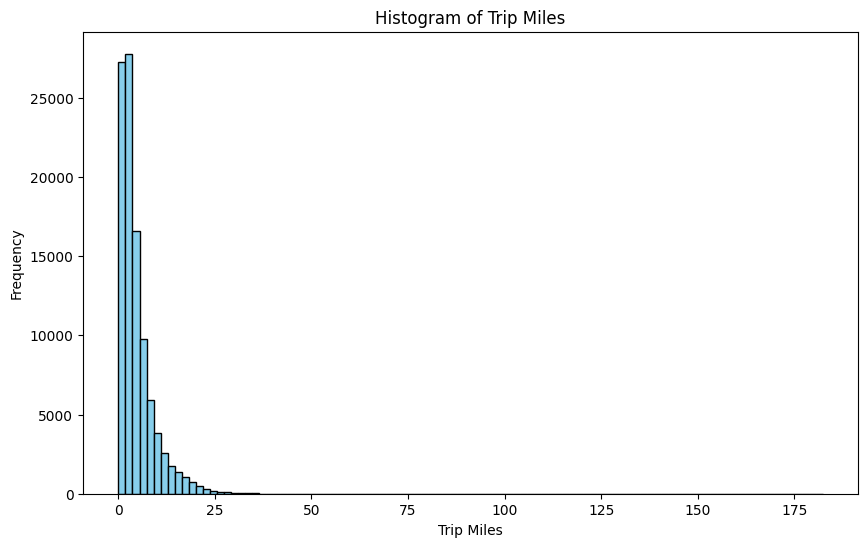

In [51]:
# Generate a histogram for 'trip_miles' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['trip_miles'], bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Trip Miles')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Miles')

plt.show()

In [52]:
max(trips['trip_miles'])

182.43

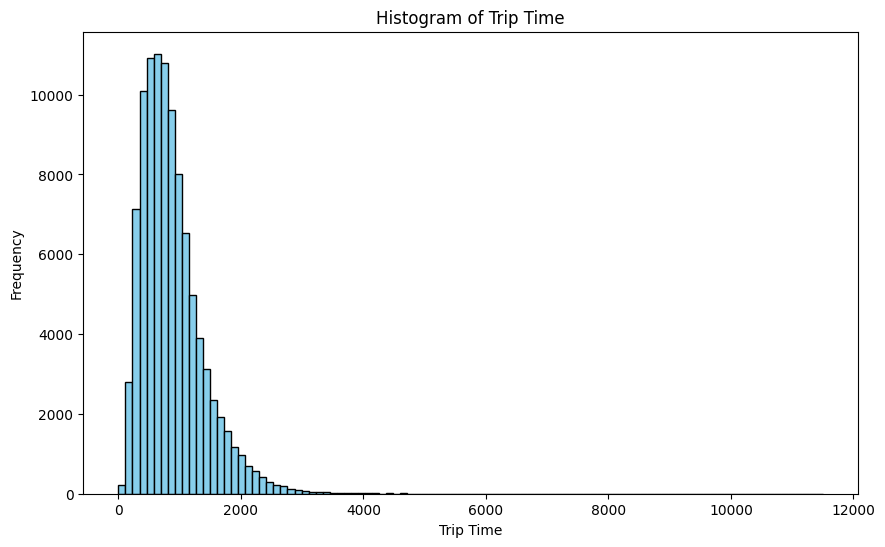

In [53]:
# Generate a histogram for 'trip_miles' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['trip_time'], bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Trip Time')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Time')

plt.show()

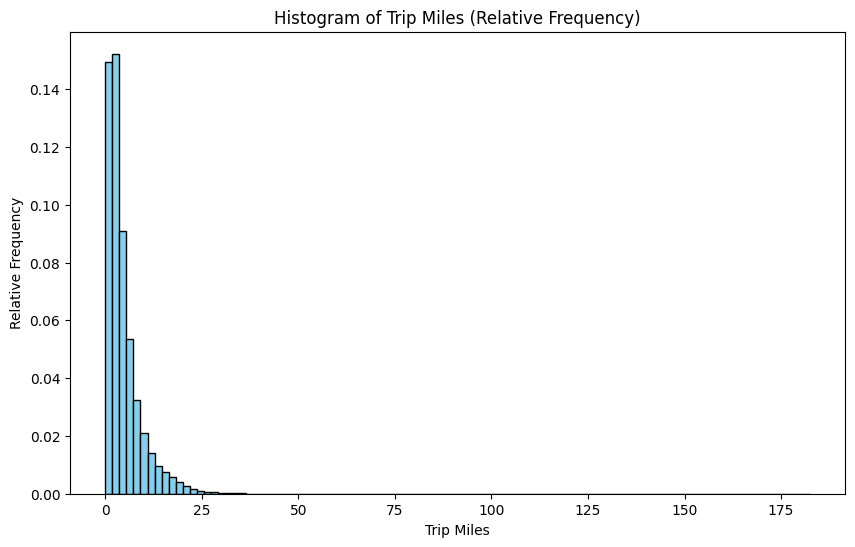

In [55]:
# Generate a histogram for 'trip_miles' with 100 bins and relative frequency
plt.figure(figsize=(10, 6))
plt.hist(trips['trip_miles'], bins=100, color='skyblue', edgecolor='black', density=True)

# Add labels and title
plt.xlabel('Trip Miles')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Trip Miles (Relative Frequency)')

plt.show()

In [78]:
trips['trip_miles'].describe()

count    100000.000000
mean          4.724523
std           4.702876
min           0.000000
25%           1.717750
50%           3.226500
75%           6.004000
max         182.430000
Name: trip_miles, dtype: float64

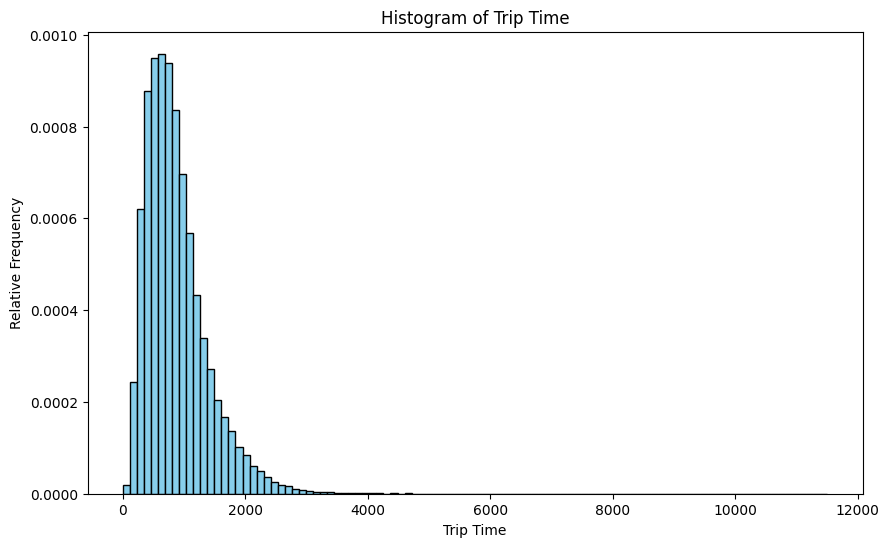

In [56]:
# Generate a histogram for 'trip_miles' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['trip_time'], bins=100, color='skyblue', edgecolor='black', density=True)

# Add labels and title
plt.xlabel('Trip Time')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Trip Time')

plt.show()

In [ ]:
max(trips['trip_time'])

11501

In [76]:
trips['trip_time'].describe()

count    100000.000000
mean        874.033370
std         510.041797
min           1.000000
25%         511.000000
50%         773.000000
75%        1111.000000
max       11501.000000
Name: trip_time, dtype: float64

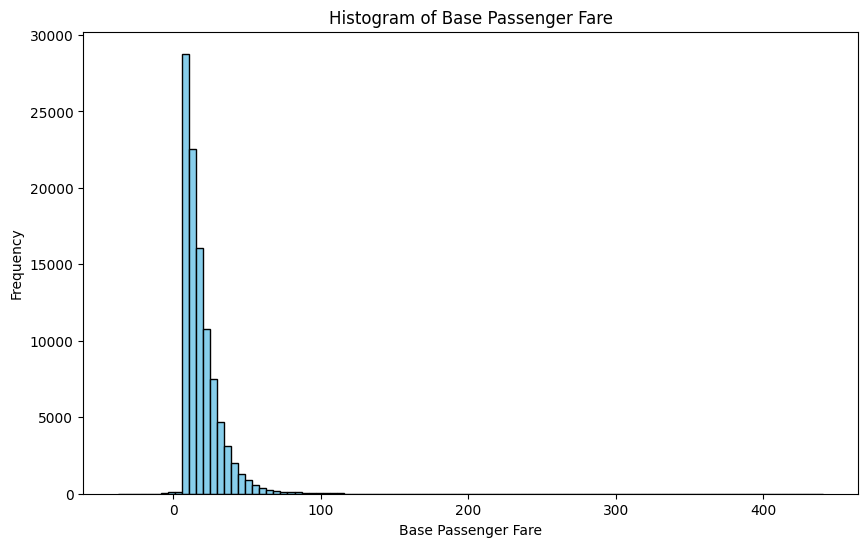

In [61]:
# Generate a histogram for 'base_passenger_fare' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['base_passenger_fare'], bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Base Passenger Fare')
plt.ylabel('Frequency')
plt.title('Histogram of Base Passenger Fare')

plt.show()

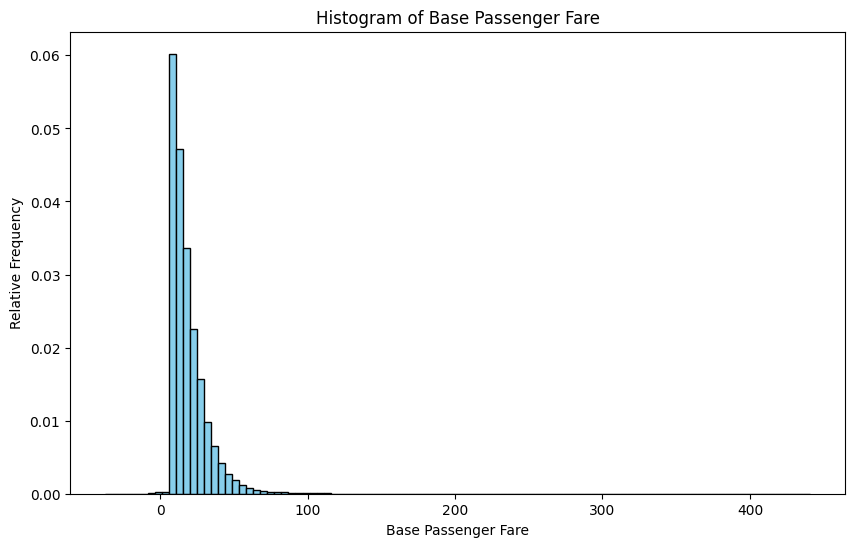

In [62]:
# Generate a histogram for 'base_passenger_fare' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['base_passenger_fare'], bins=100, color='skyblue', edgecolor='black', density=True)

# Add labels and title
plt.xlabel('Base Passenger Fare')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Base Passenger Fare')

plt.show()

In [75]:
trips['base_passenger_fare'].describe()

count    100000.000000
mean         18.692175
std          13.326185
min         -37.180000
25%           9.840000
50%          14.990000
75%          23.210000
max         440.570000
Name: base_passenger_fare, dtype: float64

In [70]:
from plotnine import ggplot, aes, geom_histogram, facet_wrap, theme_538, labs
import pandas as pd

# Reshape the data into long format
variables = ['tips', 'tolls', 'bcf', 'congestion_surcharge', 'sales_tax']
long_data = trips.melt(value_vars=variables, var_name='Variable', value_name='Value')

# Create the facet grid plot
plot = (
    ggplot(long_data, aes(x='Value')) +
    geom_histogram(bins=30, fill='skyblue', color='black') +
    facet_wrap('~Variable', scales='free') +
    theme_538() +
    labs(title='Distribution of Selected Variables', x='Value', y='Frequency')
)


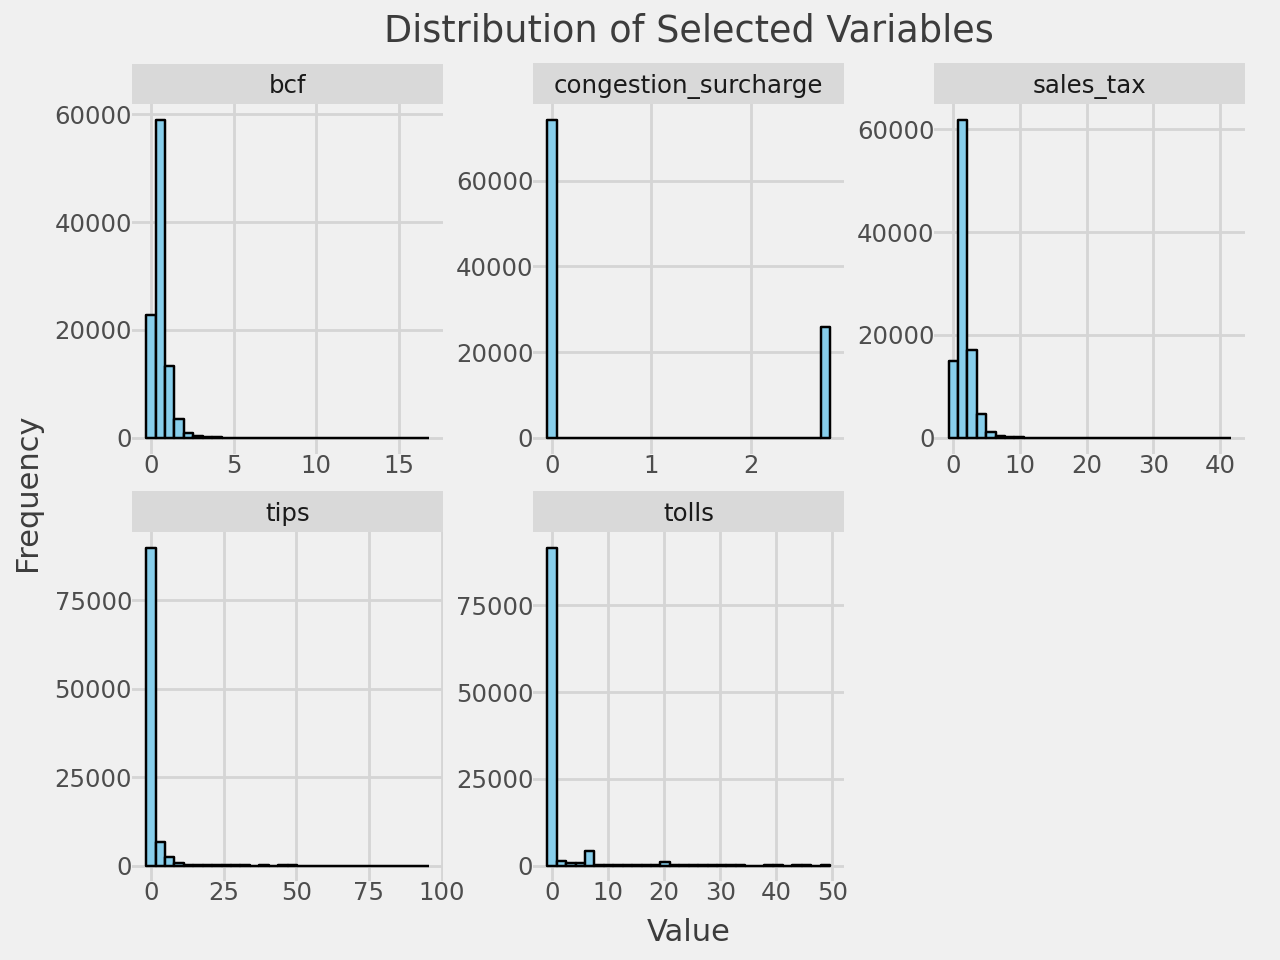

In [71]:
plot

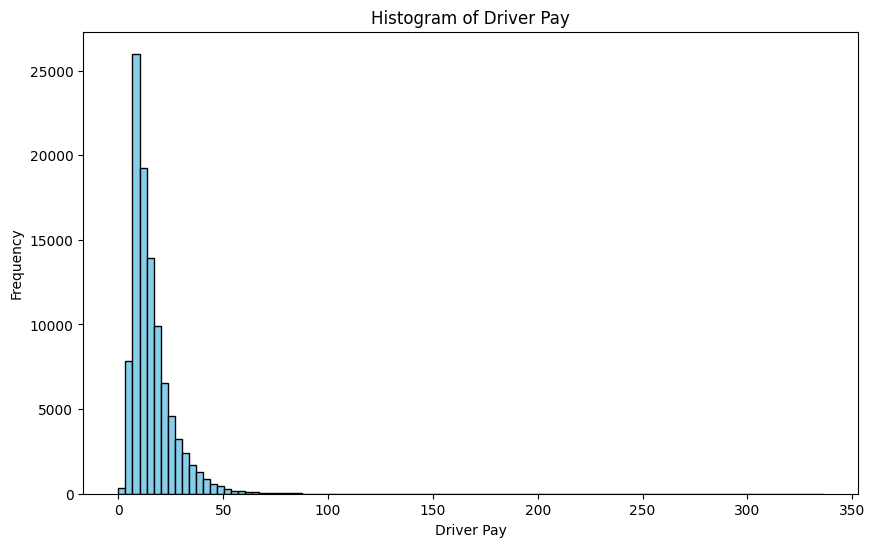

In [72]:
# Generate a histogram for 'base_passenger_fare' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['driver_pay'], bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Driver Pay')
plt.ylabel('Frequency')
plt.title('Histogram of Driver Pay')

plt.show()

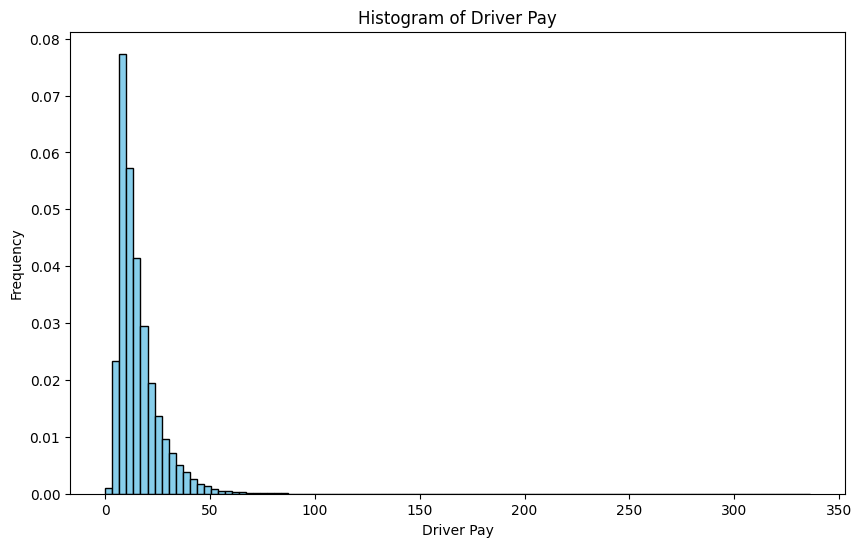

In [73]:
# Generate a histogram for 'base_passenger_fare' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['driver_pay'], bins=100, color='skyblue', edgecolor='black', density=True)

# Add labels and title
plt.xlabel('Driver Pay')
plt.ylabel('Frequency')
plt.title('Histogram of Driver Pay')

plt.show()

In [74]:
trips['driver_pay'].describe()

count    100000.000000
mean         15.695820
std          10.311479
min           0.000000
25%           8.760000
50%          12.790000
75%          19.280000
max         336.050000
Name: driver_pay, dtype: float64

In [82]:
trips['shared_request_flag'].value_counts()

shared_request_flag
N    99973
Y       27
Name: count, dtype: int64

In [84]:
trips['shared_match_flag'].value_counts()

shared_match_flag
N    100000
Name: count, dtype: int64

In [85]:
trips['access_a_ride_flag'].value_counts()

access_a_ride_flag
     72925
N    27075
Name: count, dtype: int64

In [86]:
trips['wav_request_flag'].value_counts()

wav_request_flag
N    99940
Y       60
Name: count, dtype: int64

In [87]:
trips['wav_match_flag'].value_counts()

wav_match_flag
N    97519
Y     2481
Name: count, dtype: int64

### Visualización entre pares de variables

In [98]:
trips.dtypes

hvfhs_license_num               object
dispatching_base_num            object
originating_base_num            object
request_datetime        datetime64[ns]
on_scene_datetime               object
pickup_datetime                 object
dropoff_datetime                object
PULocationID                     int64
DOLocationID                     int64
trip_miles                     float64
trip_time                        int64
base_passenger_fare            float64
tolls                          float64
bcf                            float64
sales_tax                      float64
congestion_surcharge           float64
tips                           float64
driver_pay                     float64
shared_request_flag             object
shared_match_flag               object
access_a_ride_flag              object
wav_request_flag                object
wav_match_flag                  object
request_hour                     int32
same_location                     bool
PUborough                

Relación entre variables y empresa VTC

In [99]:
trips_copy = trips.copy()

hvfhs_license_num, hvfhs_license_num, originating_base_num\
- request_datetime, on_scene_datetime, pickup_datetime, dropoff_datetime
- PULocationID, DOLocationID
- trip_miles, trip_time
- base_passenger_fare, tolls, bcf, sales_tax, congestion_surcharge, tips, driver_pay
- shared_request_flag, shared_match_flag, access_a_ride_flag, wav_request_flag, wav_match_flag

In [105]:
colors

['black', 'blue', '#fc00ed']

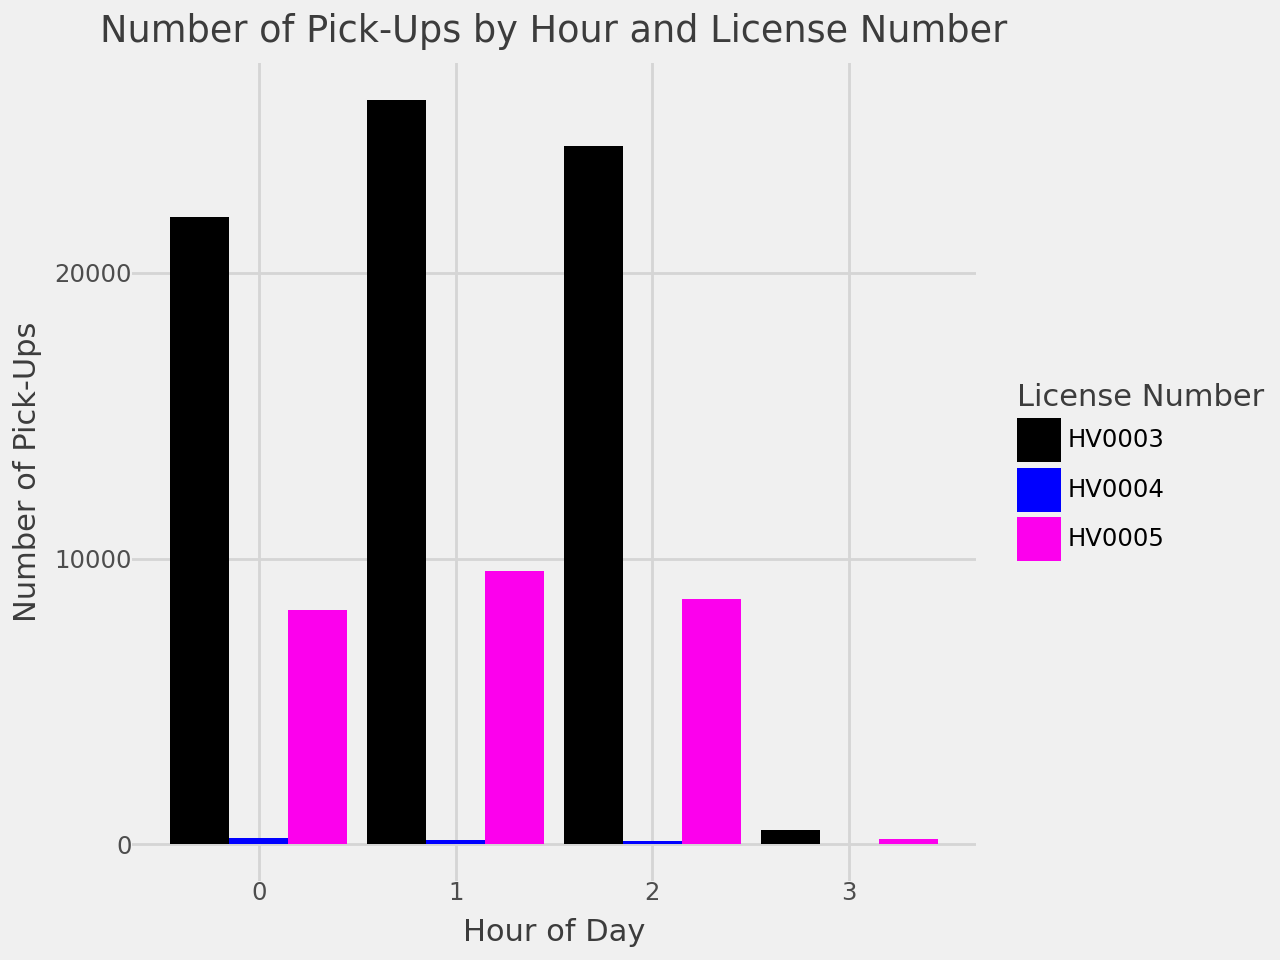

In [110]:
from plotnine import ggplot, aes, geom_col, labs, theme_minimal, scale_fill_manual
import pandas as pd

# Extract the hour from pickup_datetime
trips_copy['pickup_hour'] = trips_copy['pickup_datetime'].dt.hour

# Group by hvfhs_license_num and pickup_hour, and count the number of trips
hourly_counts = trips_copy.groupby(['hvfhs_license_num', 'pickup_hour']).size().reset_index(name='count')

# Define a mapping of license numbers to colors
license_colors = dict(zip(hourly_counts['hvfhs_license_num'].unique(), colors))

# Create the plot
plot = (
    ggplot(hourly_counts, aes(x='pickup_hour', y='count', fill='hvfhs_license_num')) +
    geom_col(position='dodge') +
    scale_fill_manual(values=license_colors) +
    labs(
        title='Number of Pick-Ups by Hour and License Number',
        x='Hour of Day',
        y='Number of Pick-Ups',
        fill='License Number'
    ) +
    theme_538()
)

plot

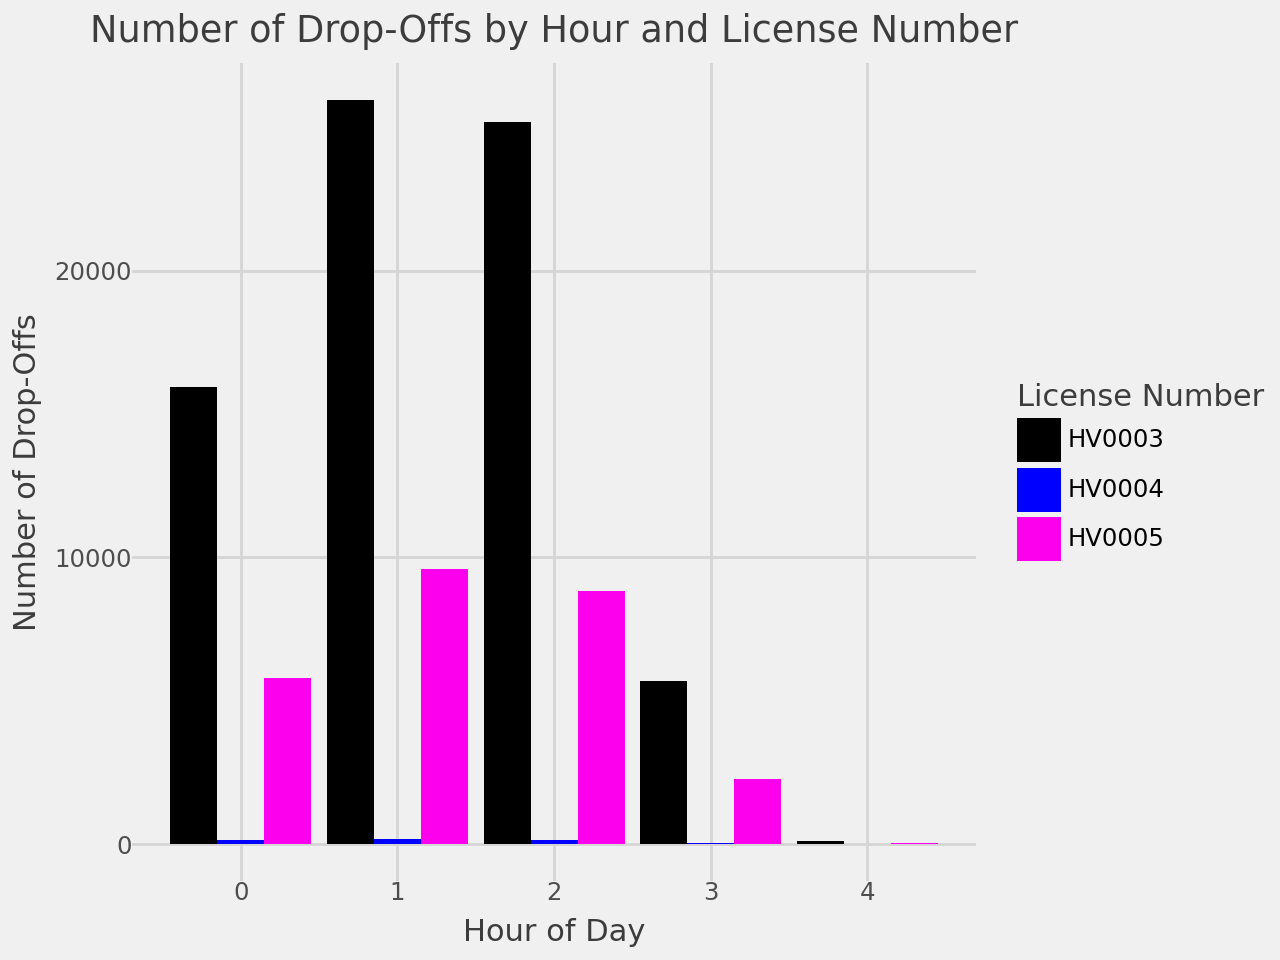

In [113]:
# Ensure dropoff_datetime is in datetime format
trips_copy['dropoff_datetime'] = pd.to_datetime(trips_copy['dropoff_datetime'])

# Extract the hour from dropoff_datetime
trips_copy['dropoff_hour'] = trips_copy['dropoff_datetime'].dt.hour

# Group by hvfhs_license_num and pickup_hour, and count the number of trips
hourly_counts = trips_copy.groupby(['hvfhs_license_num', 'dropoff_hour']).size().reset_index(name='count')

# Define a mapping of license numbers to colors
license_colors = dict(zip(hourly_counts['hvfhs_license_num'].unique(), colors))

# Create the plot
plot = (
    ggplot(hourly_counts, aes(x='dropoff_hour', y='count', fill='hvfhs_license_num')) +
    geom_col(position='dodge') +
    scale_fill_manual(values=license_colors) +
    labs(
        title='Number of Drop-Offs by Hour and License Number',
        x='Hour of Day',
        y='Number of Drop-Offs',
        fill='License Number'
    ) +
    theme_538()
)

plot

PULocationID, DOLocationID

In [115]:
# Group by 'hvfhs_license_num' and get the top 5 PULocationID for each group
top_pulocation_ids = trips_copy.groupby('hvfhs_license_num')['PULocationID'].value_counts().groupby(level=0).head(5)

# Print the result
print(top_pulocation_ids)

hvfhs_license_num  PULocationID
HV0003             37              1415
                   61              1397
                   42              1152
                   244             1116
                   76               973
HV0004             166               23
                   41                16
                   37                15
                   42                15
                   74                13
HV0005             61               654
                   37               578
                   42               429
                   225              394
                   17               371
Name: count, dtype: int64


In [116]:
# Group by 'hvfhs_license_num' and get the top 5 PULocationID for each group
top_dolocation_ids = trips_copy.groupby('hvfhs_license_num')['DOLocationID'].value_counts().groupby(level=0).head(5)

# Print the result
print(top_dolocation_ids)

hvfhs_license_num  DOLocationID
HV0003             265             1814
                   61              1441
                   37              1330
                   42              1084
                   244             1081
HV0004             166               23
                   74                17
                   75                16
                   263               15
                   41                12
HV0005             265             1053
                   61               661
                   37               575
                   42               450
                   17               431
Name: count, dtype: int64


In [126]:
gdf.loc[gdf['LocationID'] == 61]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,taxi_zone_lookup_LocationID,geometry
60,61,0.117311,0.000511,Crown Heights North,61,Brooklyn,None,"MULTIPOLYGON (((1003897.089 188278.65, 1003939..."


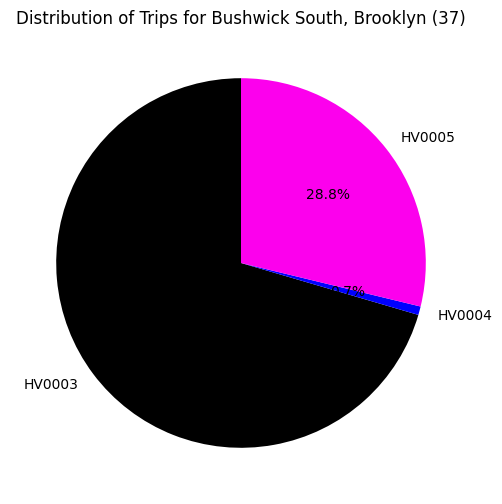

In [124]:
# Filter data for PULocationID == 37
pulocation_37 = top_pulocation_ids.loc[(slice(None), 37)].reset_index()
pulocation_37.columns = ['hvfhs_license_num', 'count']

# Create proportions for the pie chart
proportions = pulocation_37['count'] / pulocation_37['count'].sum()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(proportions, labels=pulocation_37['hvfhs_license_num'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Trips for Bushwick South, Brooklyn (37)')
plt.show()

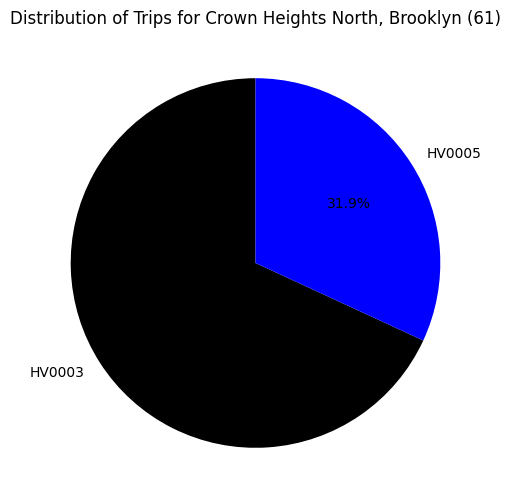

In [128]:
# Filter data for PULocationID == 37
pulocation_61 = top_pulocation_ids.loc[(slice(None), 61)].reset_index()
pulocation_61.columns = ['hvfhs_license_num', 'count']

# Create proportions for the pie chart
proportions = pulocation_61['count'] / pulocation_61['count'].sum()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(proportions, labels=pulocation_61['hvfhs_license_num'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Trips for Crown Heights North, Brooklyn (61)')
plt.show()

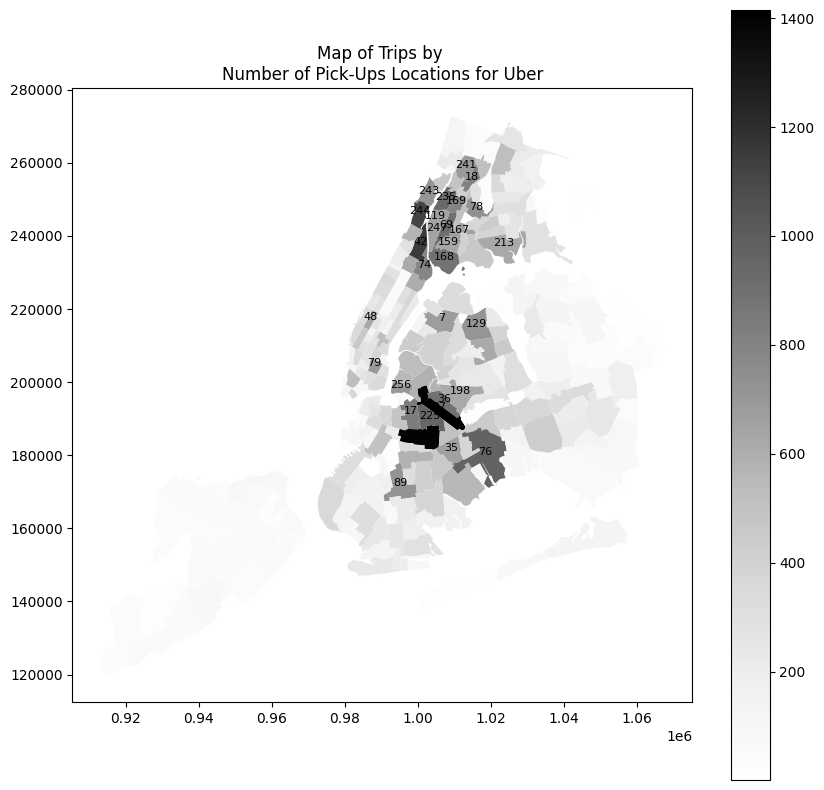

In [154]:
# Filter gdf to include only the DOLocationIDs present in trips with 'hvfhs_license_num' == 'HV0003'
filtered_trips_hv0003 = trips[trips['hvfhs_license_num'] == 'HV0003']
filtered_gdf = gdf[gdf['LocationID'].isin(filtered_trips_hv0003['PULocationID'].value_counts().index)]

# Merge the value counts with the filtered GeoDataFrame
value_counts = filtered_trips_hv0003['PULocationID'].value_counts()
filtered_gdf = filtered_gdf.merge(value_counts.rename('count'), left_on='LocationID', right_index=True)

# Plot the map
ax = filtered_gdf.plot(column='count', legend=True, cmap='Greys', figsize=(10, 10))
plt.title("Map of Trips by \nNumber of Pick-Ups Locations for Uber")

# Add labels for the top 10 LocationIDs
top_10 = value_counts.head(30)
for loc_id in top_10.index:
    row = filtered_gdf[filtered_gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

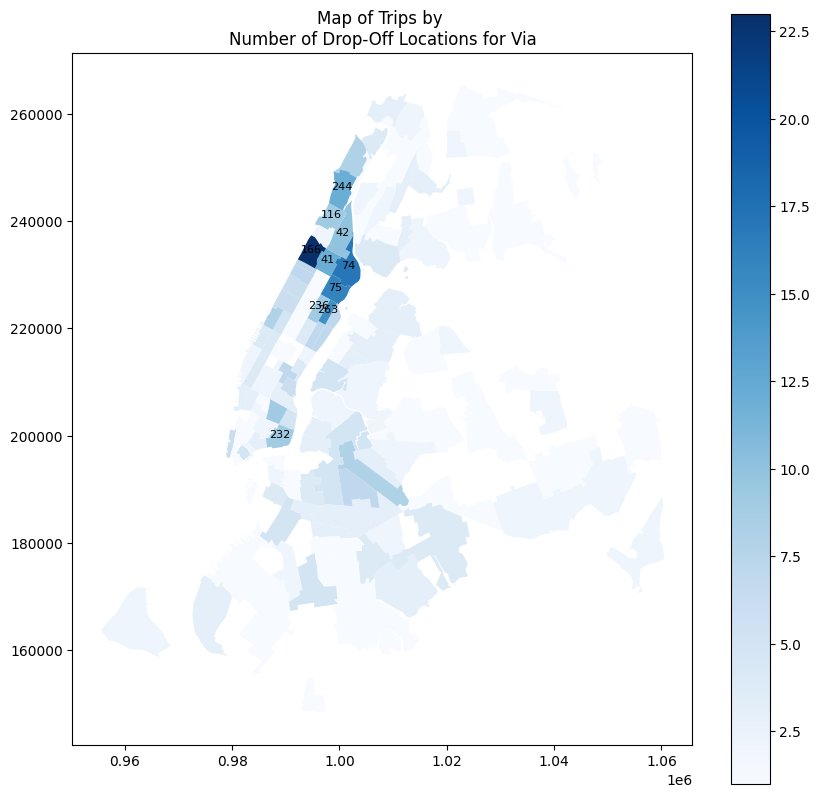

In [131]:
# Filter gdf to include only the DOLocationIDs present in trips with 'hvfhs_license_num' == 'HV0003'
filtered_trips_hv0004 = trips[trips['hvfhs_license_num'] == 'HV0004']
filtered_gdf = gdf[gdf['LocationID'].isin(filtered_trips_hv0004['DOLocationID'].value_counts().index)]

# Merge the value counts with the filtered GeoDataFrame
value_counts = filtered_trips_hv0004['DOLocationID'].value_counts()
filtered_gdf = filtered_gdf.merge(value_counts.rename('count'), left_on='LocationID', right_index=True)

# Plot the map
ax = filtered_gdf.plot(column='count', legend=True, cmap='Blues', figsize=(10, 10))
plt.title("Map of Trips by \nNumber of Drop-Off Locations for Via")

# Add labels for the top 10 LocationIDs
top_10 = value_counts.head(10)
for loc_id in top_10.index:
    row = filtered_gdf[filtered_gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

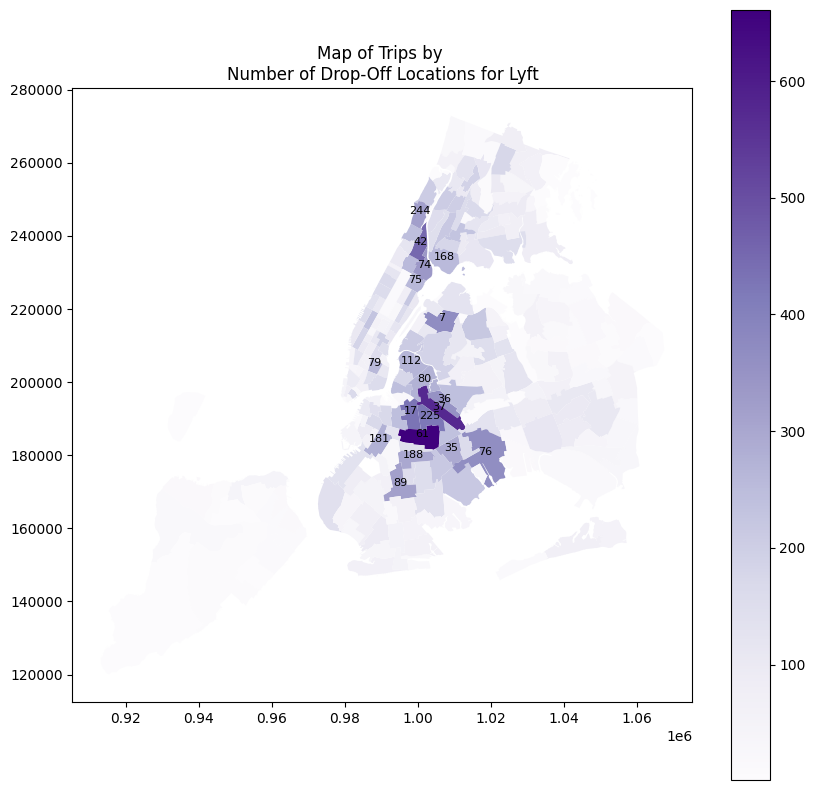

In [141]:
# Filter gdf to include only the DOLocationIDs present in trips with 'hvfhs_license_num' == 'HV0003'
filtered_trips_hv0005 = trips[trips['hvfhs_license_num'] == 'HV0005']
filtered_gdf = gdf[gdf['LocationID'].isin(filtered_trips_hv0005['DOLocationID'].value_counts().index)]

# Merge the value counts with the filtered GeoDataFrame
value_counts = filtered_trips_hv0005['DOLocationID'].value_counts()
filtered_gdf = filtered_gdf.merge(value_counts.rename('count'), left_on='LocationID', right_index=True)

# Plot the map
ax = filtered_gdf.plot(column='count', legend=True, cmap='Purples', figsize=(10, 10))
plt.title("Map of Trips by \nNumber of Drop-Off Locations for Lyft")

# Add labels for the top 10 LocationIDs
top_10 = value_counts.head(20)
for loc_id in top_10.index:
    row = filtered_gdf[filtered_gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

In [143]:
# Group by 'hvfhs_license_num' and 'PULocationID' to calculate the total counts
pulocation_counts = trips.groupby(['hvfhs_license_num', 'PULocationID']).size().unstack(fill_value=0)

# Determine the license with the highest count for each 'PULocationID'
dominant_license = pulocation_counts.idxmax()

# Map the dominant license to colors
license_color_map = {'HV0003': 'black', 'HV0004': 'blue', 'HV0005': '#fc00ed'}
location_colors = dominant_license.map(license_color_map)

# Merge the colors into the GeoDataFrame
gdf['color'] = gdf['LocationID'].map(location_colors)


/tmp/ipykernel_510929/116569298.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




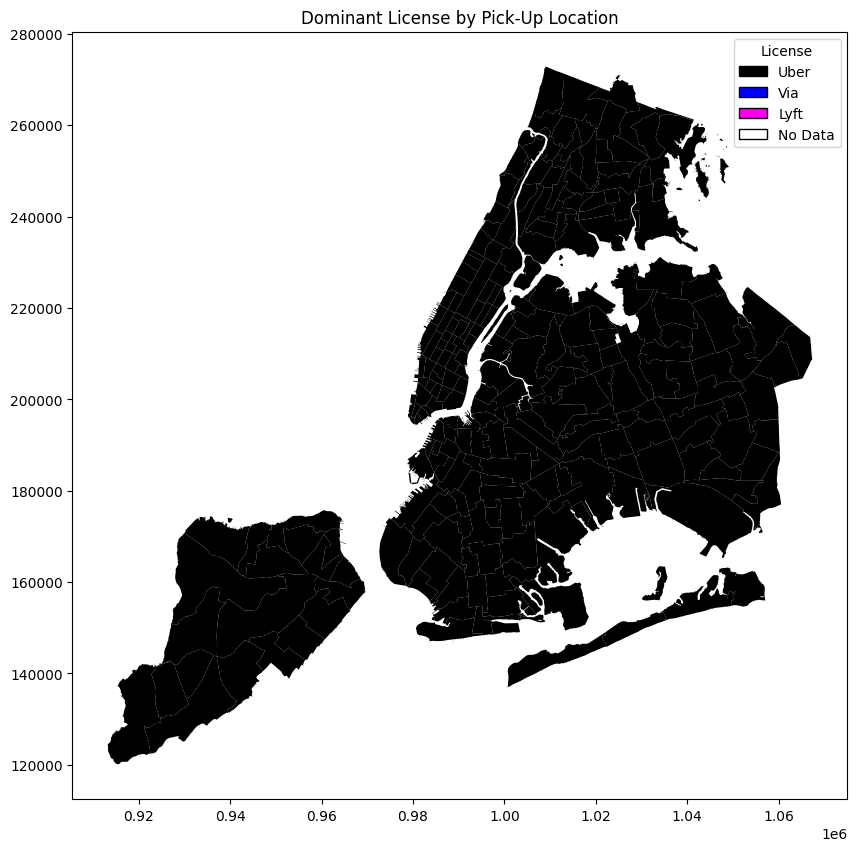

In [147]:
from matplotlib.patches import Patch

# Fill missing colors with white
gdf['color'].fillna('white', inplace=True)

# Plot the map with the assigned colors
ax = gdf.plot(color=gdf['color'], figsize=(10, 10))
plt.title("Dominant License by Pick-Up Location")

# Create a custom legend
legend_elements = [
    Patch(facecolor='black', edgecolor='black', label='Uber'),
    Patch(facecolor='blue', edgecolor='black', label='Via'),
    Patch(facecolor='#fc00ed', edgecolor='black', label='Lyft'),
    Patch(facecolor='white', edgecolor='black', label='No Data')
]
plt.legend(handles=legend_elements, title="License", loc='upper right')

plt.show()

In [148]:
pulocation_counts

PULocationID,3,4,5,6,7,8,9,10,11,12,...,255,256,257,258,259,260,261,262,263,265
hvfhs_license_num,,,,,,,,,,,,,,,,,,,,,
HV0003,185,298,33,49,678,3,54,225,98,1,...,551,701,103,376,263,327,125,236,377,2
HV0004,1,6,0,0,6,0,0,0,0,1,...,6,6,1,0,1,0,1,9,8,0
HV0005,55,93,7,14,255,0,14,104,22,1,...,253,318,47,114,134,88,69,111,176,2


In [149]:
difference_license = pulocation_counts.loc['HV0003'] - pulocation_counts.loc['HV0005']

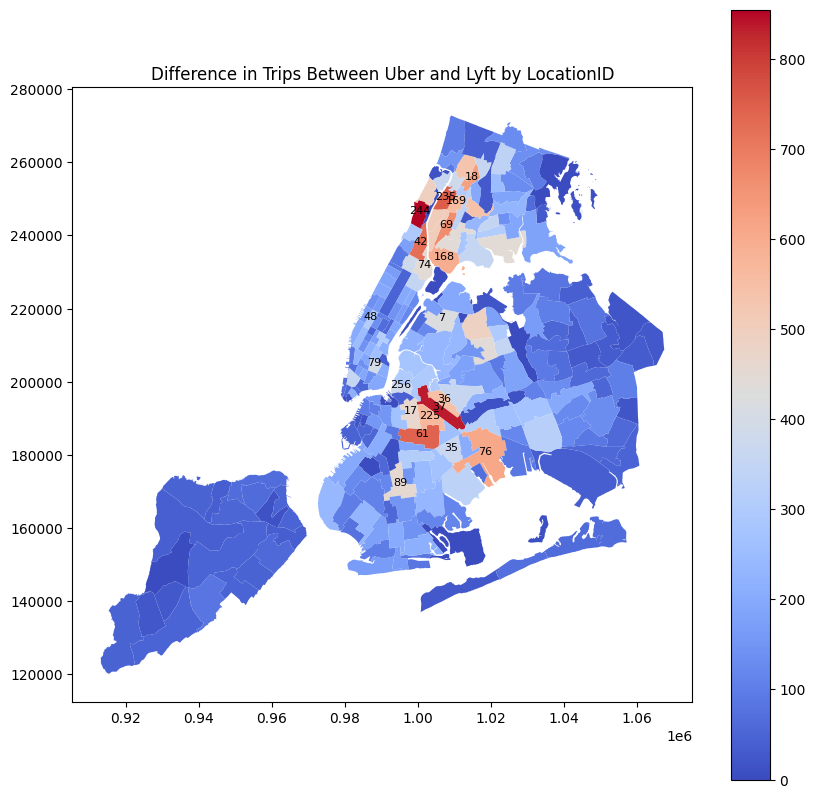

In [160]:
# Merge the difference_license data with the GeoDataFrame
gdf['difference'] = gdf['LocationID'].map(difference_license)
top_20_locations = total_counts.nlargest(20)

# Plot the map
ax = gdf.plot(column='difference', legend=True, cmap='coolwarm', figsize=(10, 10))
plt.title("Difference in Trips Between Uber and Lyft by LocationID")

# Add labels for the top 20 LocationIDs
for loc_id in top_20_locations.index:
    row = gdf[gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')
        
plt.show()

In [155]:
total_counts = pulocation_counts.sum()
difference_license_pct = ((pulocation_counts.loc['HV0003'] - pulocation_counts.loc['HV0005']) / total_counts) * 100
difference_license_pct

PULocationID
3      53.941909
4      51.637280
5      65.000000
6      55.555556
7      45.047923
         ...    
260    57.590361
261    28.717949
262    35.112360
263    35.828877
265     0.000000
Length: 256, dtype: float64

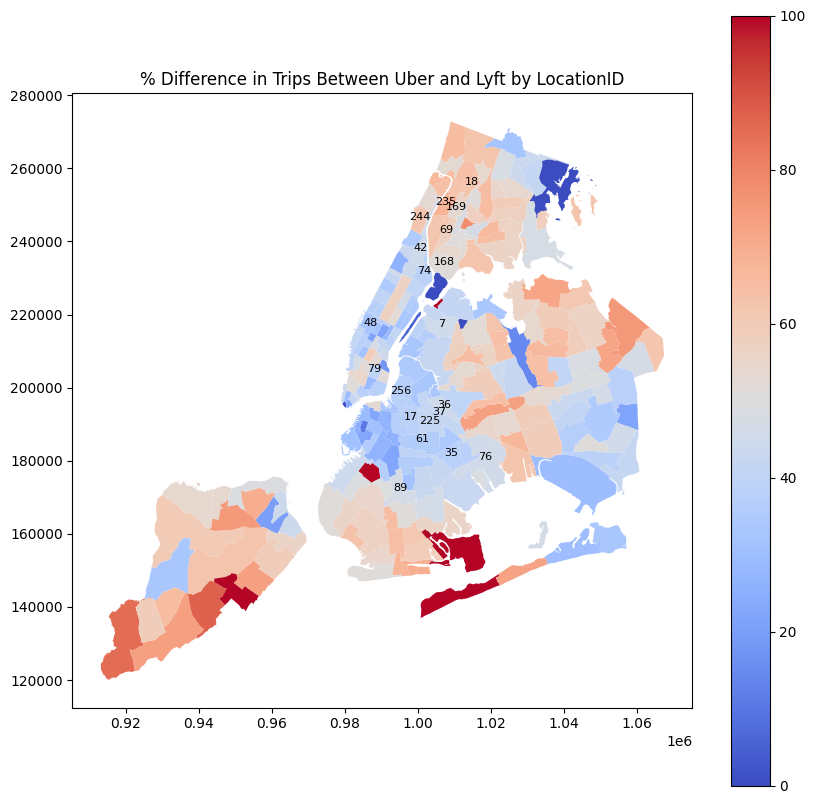

In [159]:
# Filter the top 20 LocationIDs based on total_counts
top_20_locations = total_counts.nlargest(20)

# Plot the map
ax = gdf.plot(column='difference_license_pct', legend=True, cmap='coolwarm', figsize=(10, 10))
plt.title("% Difference in Trips Between Uber and Lyft by LocationID")

# Add labels for the top 20 LocationIDs
for loc_id in top_20_locations.index:
    row = gdf[gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

trip_miles, trip_time

In [ ]:
trips_copy.loc[:,['trip_miles','hvfhs_license_num']].groupby('hvfhs_license_num').describe()

trip_miles                                                  \
                       count      mean       std  min    25%    50%      75%   
hvfhs_license_num                                                              
HV0003               72925.0  4.585367  4.613811  0.0  1.660  3.110  5.81000   
HV0004                 501.0  6.413493  5.185229  0.0  2.120  5.270  8.84000   
HV0005               26574.0  5.074555  4.906804  0.0  1.891  3.526  6.48875   

                            
                       max  
hvfhs_license_num           
HV0003             182.430  
HV0004              28.000  
HV0005              90.675

In [ ]:
trips_copy.loc[:,['trip_time','hvfhs_license_num']].groupby('hvfhs_license_num').describe()

trip_time                                               \
                      count         mean         std   min    25%    50%   
hvfhs_license_num                                                          
HV0003              72925.0   847.861529  499.022239  10.0  492.0  747.0   
HV0004                501.0  1057.986028  566.437560   7.0  657.0  981.0   
HV0005              26574.0   942.386694  531.361239   1.0  568.0  839.5   

                                    
                      75%      max  
hvfhs_license_num                   
HV0003             1079.0  11501.0  
HV0004             1423.0   2994.0  
HV0005             1188.0   8411.0

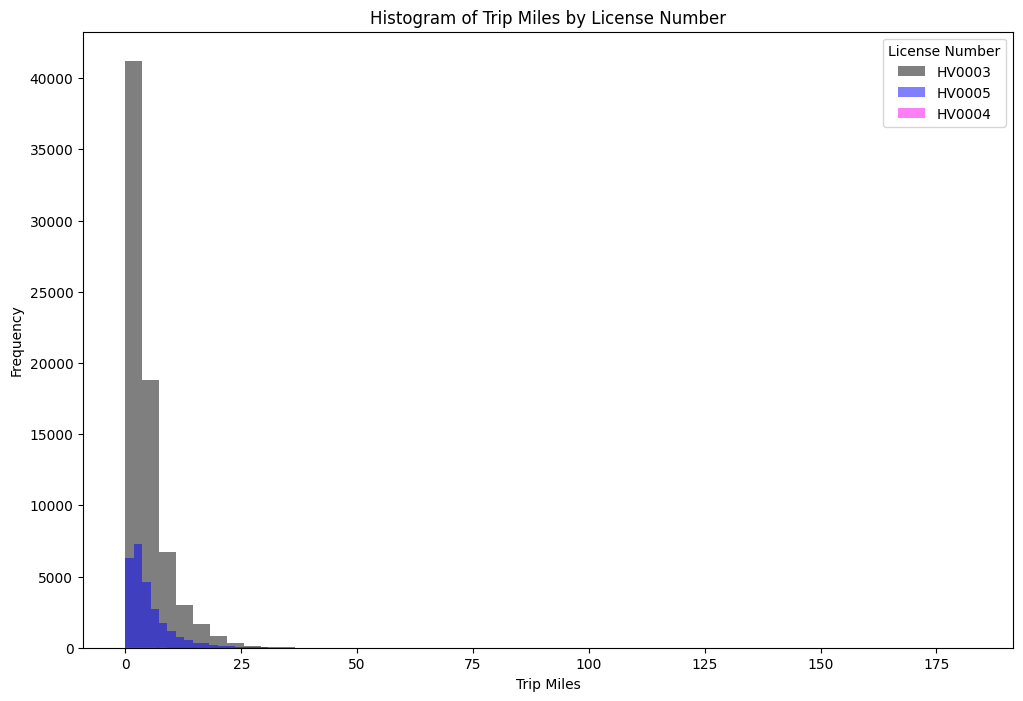

In [172]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Create histograms for each hvfhs_license_num
unique_license_nums = trips_copy['hvfhs_license_num'].unique()

# Set up the figure
plt.figure(figsize=(12, 8))

# Loop through each unique license number and plot a histogram
for license_num, color in zip(unique_license_nums, colors):
    subset = trips_copy[trips_copy['hvfhs_license_num'] == license_num]
    plt.hist(subset['trip_miles'], bins=50, alpha=0.5, label=license_num, color=color)

# Add labels, title, and legend
plt.xlabel('Trip Miles')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Miles by License Number')
plt.legend(title='License Number')
plt.show()

In [174]:
trips_copy.loc[:,['driver_pay','hvfhs_license_num']].groupby('hvfhs_license_num').describe()

driver_pay                                                  \
                       count       mean        std   min   25%    50%    75%   
hvfhs_license_num                                                              
HV0003               72925.0  15.582198   9.990018  0.00  8.95  12.73  18.88   
HV0004                 501.0  12.980319  10.573234  0.00  3.90  11.82  19.70   
HV0005               26574.0  16.058817  11.128122  5.47  8.02  12.98  20.51   

                           
                      max  
hvfhs_license_num          
HV0003             336.05  
HV0004              50.17  
HV0005             208.22

In [175]:
trips_copy.dtypes

hvfhs_license_num               object
dispatching_base_num            object
originating_base_num            object
request_datetime        datetime64[ns]
on_scene_datetime               object
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
PULocationID                     int64
DOLocationID                     int64
trip_miles                     float64
trip_time                        int64
base_passenger_fare            float64
tolls                          float64
bcf                            float64
sales_tax                      float64
congestion_surcharge           float64
tips                           float64
driver_pay                     float64
shared_request_flag             object
shared_match_flag               object
access_a_ride_flag              object
wav_request_flag                object
wav_match_flag                  object
request_hour                     int32
same_location                     bool
PUborough                

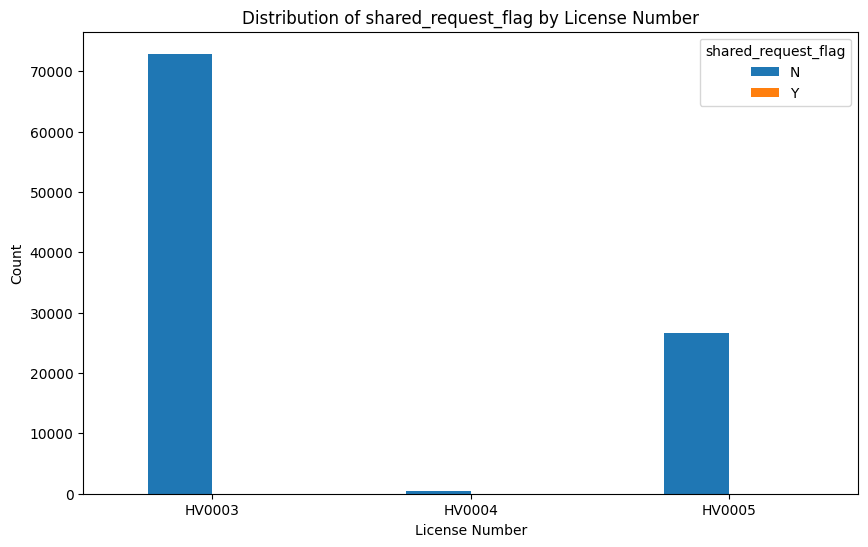

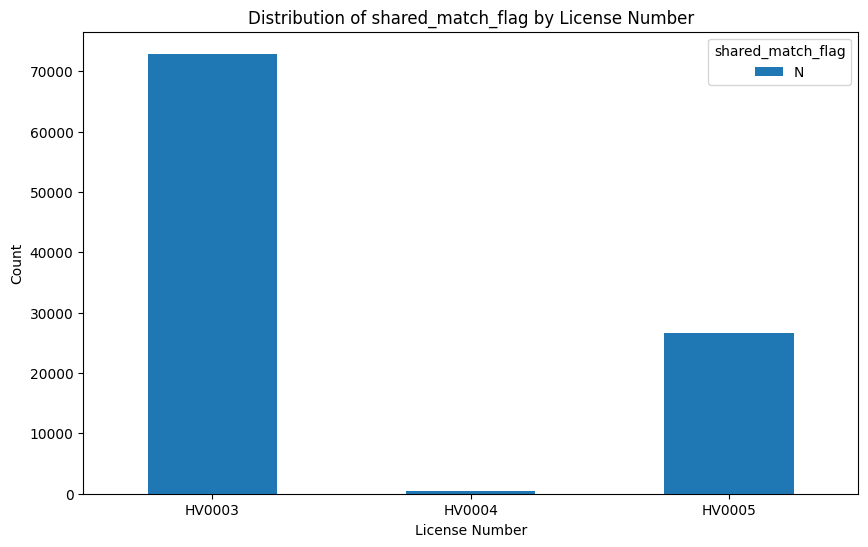

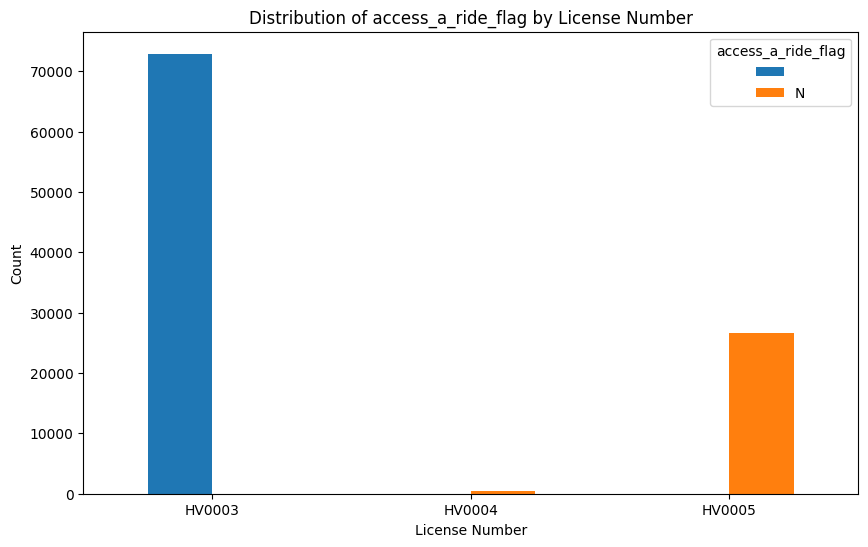

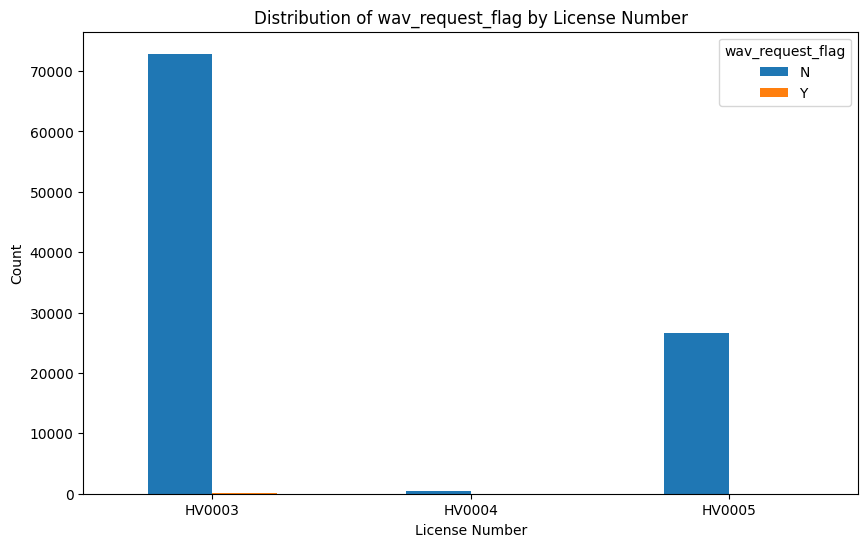

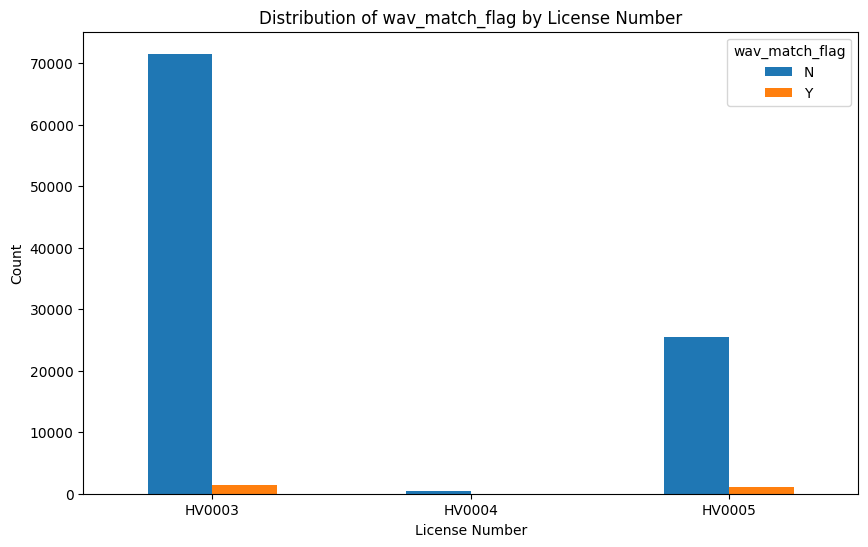

In [177]:
import matplotlib.pyplot as plt

# List of columns to plot
columns_to_plot = ['shared_request_flag', 'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag']

# Loop through each column and generate a bar plot
for column in columns_to_plot:
    # Group by 'hvfhs_license_num' and the column, then count occurrences
    grouped_data = trips_copy.groupby(['hvfhs_license_num', column]).size().unstack(fill_value=0)
    
    # Plot the data
    grouped_data.plot(kind='bar', figsize=(10, 6), stacked=False)
    
    # Add labels and title
    plt.xlabel('License Number')
    plt.ylabel('Count')
    plt.title(f'Distribution of {column} by License Number')
    plt.xticks(rotation=0)
    
    # Show the plot
    plt.show()

In [178]:
trips_copy.dtypes

hvfhs_license_num               object
dispatching_base_num            object
originating_base_num            object
request_datetime        datetime64[ns]
on_scene_datetime               object
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
PULocationID                     int64
DOLocationID                     int64
trip_miles                     float64
trip_time                        int64
base_passenger_fare            float64
tolls                          float64
bcf                            float64
sales_tax                      float64
congestion_surcharge           float64
tips                           float64
driver_pay                     float64
shared_request_flag             object
shared_match_flag               object
access_a_ride_flag              object
wav_request_flag                object
wav_match_flag                  object
request_hour                     int32
same_location                     bool
PUborough                

### Matriz de correlaciones

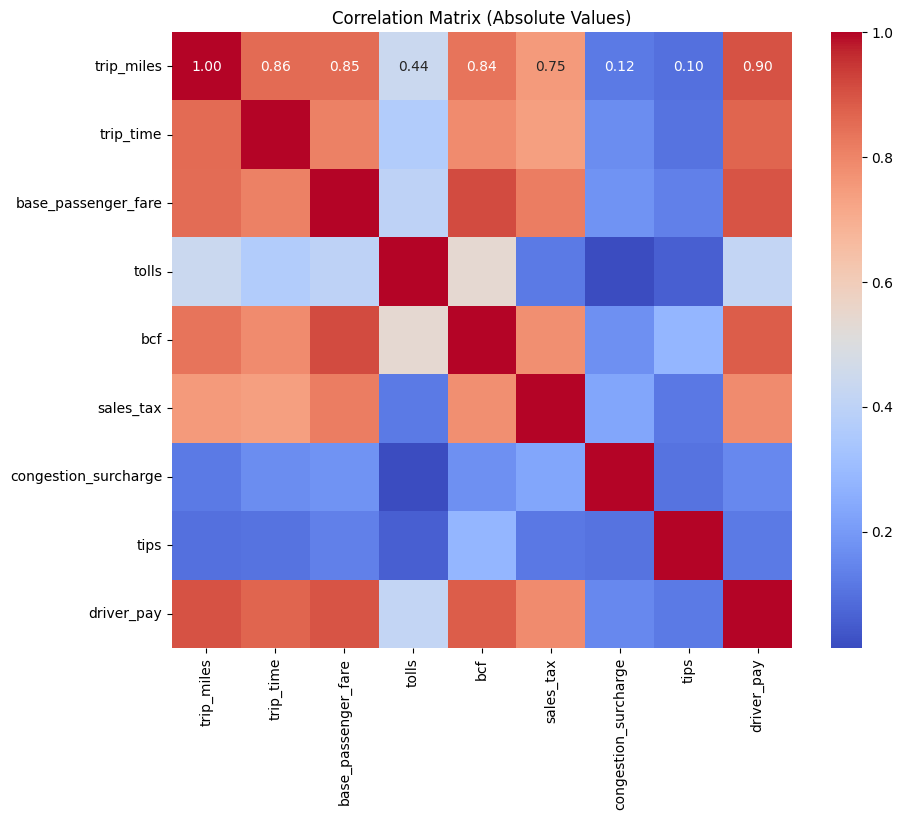

In [96]:
import seaborn as sns

import matplotlib.pyplot as plt

# Select numeric columns excluding PULocationID and DOLocationID
numeric_columns = trips.select_dtypes(include=['number']).drop(columns=['PULocationID', 'DOLocationID','request_hour'])

# Compute the correlation matrix and take absolute values
correlation_matrix = numeric_columns.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix (Absolute Values)')
plt.show()

## Outliers

## Feature Engineering
- Tiempo de viaje
- Velocidad media